# EDA Case Study

# Data Analysis and Cleansing
First load the loan.csv file and treat the data. 

Remove columns where 90% or more of the rows are empty.

Remove special charaters and text from columns term,int_rate,revol_util and emp_lenght - Remove 'month','%','months','years','+','<'.

Convert int_rate and emp_lenght to numeric columns.

For simplicity - Add a loan_status_cat column with 2 categories of loan_status- 'Default'(Charged Off) and 'Non-Default'(Current and Fully Paid).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from scipy.stats import linregress
from matplotlib import cm as cm
from pandas.plotting import scatter_matrix
import statsmodels.api as sm

# Load the loan.csv file
loan = pd.read_csv("loan.csv", encoding="ISO-8859-1", engine="python")
loan.info()

C:\Users\Z001MC7\AppData\Local\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [2]:
print('Before removing outliers', loan.shape)

# Retain Columns that have less than 90% of null values
loan = pd.DataFrame(loan[loan.columns[loan.isnull().mean() < 0.9]])
# Retain Rows where employee length and revol_util is not null
loan = loan.dropna(subset=['emp_length','revol_util'])
# Remove loans that are above 204000 as those are outliers
loan = loan[loan['annual_inc'] < 204000]

print('After removing outliers', loan.shape)

Before removing outliers (39717, 111)
After removing outliers (38042, 55)


In [3]:
# Remove characters and strings not needed for analysis.
# Remove months from term
# Replace NA with 0 for tax_liens
# Remove % from interest rate and revol_util
loan['term'] = loan['term'].apply(lambda x: x.rstrip('months').strip())
loan['int_rate'] = loan['int_rate'].apply(lambda x: x.rstrip('%').strip())
loan['revol_util'] = loan['revol_util'].apply(lambda x: x.rstrip('%').strip())
loan['tax_liens'] = loan['int_rate'].apply(lambda x: x.replace('NA','0'))

# New Column for loan status categories - default or Non-default
# Convert employee length to make it a number
# Convert interest rate and employee length to numeric types
loan['loan_status_cat'] = loan['loan_status'].apply(
    lambda x: x.replace('Charged Off','Default').replace('Current','Non-Default').replace('Fully Paid','Non-Default'))
loan['emp_length'] = loan['emp_length'].apply(
    lambda x: x.replace('year','').replace('s','').replace('<','').replace('+',''))

loan['int_rate'] = (loan['int_rate']).astype(float)
loan['emp_length'] = (loan['emp_length']).astype(int)

# Percentage of missing values in each column
print("Percentage of missing values in each column\n{0}".format(
    round(100*(loan.isnull().sum()/len(loan.index)),2)))
print(loan.shape)

Percentage of missing values in each column
id                             0.00
member_id                      0.00
loan_amnt                      0.00
funded_amnt                    0.00
funded_amnt_inv                0.00
term                           0.00
int_rate                       0.00
installment                    0.00
grade                          0.00
sub_grade                      0.00
emp_title                      3.64
emp_length                     0.00
home_ownership                 0.00
annual_inc                     0.00
verification_status            0.00
issue_d                        0.00
loan_status                    0.00
pymnt_plan                     0.00
url                            0.00
desc                          32.34
purpose                        0.00
title                          0.03
zip_code                       0.00
addr_state                     0.00
dti                            0.00
delinq_2yrs                    0.00
earliest_cr_line    

In [4]:
# Create a loan group category by grouping the types of Historical loan applications and status
# Most analysis will be over defaulter data only
loan_group_cat = loan.groupby(['loan_status_cat'],as_index=False)
cat_total = loan_group_cat.loan_amnt.count() 
cat_total

,loan_status_cat,loan_amnt
0,Default,5328
1,Non-Default,32714


In [5]:
# Separate out data for defaulters and non defaulters
loan_def = loan.loc[loan['loan_status_cat'].isin(['Default'])]
loan_nondef = loan.loc[loan['loan_status_cat'].isin(['Non-Default'])]

print (loan_def.shape)
print (loan_nondef.shape)

(5328, 56)
(32714, 56)


# Individual Column analysis (Univariate)
Extract data for both numerical and categorical variables for below columns - 

  categorical - home_ownership, term, verificationstatus addr_state, grade, purpose, annual_inc 

  numerical - installment, loan_amnt, int_rate, dti, emp_lentgh, revol_util, total_acc
  
We are going to add additional columns for ranges of different numerical columns

In [6]:
# Analyse defaulters by categorical columns
# home ownership, term, verification status, state, grade, purpose 
home_status_sort = {'def': pd.DataFrame(loan_def.groupby(
    ['home_ownership'],as_index=False).loan_amnt.count()).sort_values(by=['loan_amnt'],ascending=False),
                   'non-def': pd.DataFrame(loan_nondef.groupby(
    ['home_ownership'],as_index=False).loan_amnt.count()).sort_values(by=['loan_amnt'],ascending=False)}

term_status_sort = {'def': pd.DataFrame(loan_def.groupby(
    ['term'],as_index=False).loan_amnt.count()).sort_values(by=['loan_amnt'],ascending=False),
                    'non-def': pd.DataFrame(loan_nondef.groupby(
    ['term'],as_index=False).loan_amnt.count()).sort_values(by=['loan_amnt'],ascending=False)}

verify_status_sort = {'def': pd.DataFrame(loan_def.groupby(
    ['verification_status'],as_index=False).loan_amnt.count()).sort_values(by=['loan_amnt'],ascending=False),
                      'non-def': pd.DataFrame(loan_nondef.groupby(
    ['verification_status'],as_index=False).loan_amnt.count()).sort_values(by=['loan_amnt'],ascending=False)}

state_status_sort = {'def': pd.DataFrame(loan_def.groupby(
    ['addr_state'],as_index=False).loan_amnt.count()).sort_values(by=['loan_amnt'],ascending=False), 
                     'non-def': pd.DataFrame(loan_nondef.groupby(
    ['addr_state'],as_index=False).loan_amnt.count()).sort_values(by=['loan_amnt'],ascending=False)}

grade_status_sort = {'def': pd.DataFrame(loan_def.groupby(
    ['grade'],as_index=False).loan_amnt.count()).sort_values(by=['loan_amnt'],ascending=False),
                     'non-def': pd.DataFrame(loan_nondef.groupby(
    ['grade'],as_index=False).loan_amnt.count()).sort_values(by=['loan_amnt'],ascending=False)}

purpose_status_sort = {'def': pd.DataFrame(loan_def.groupby(
    ['purpose'],as_index=False).loan_amnt.count()).sort_values(by=['loan_amnt'],ascending=False),
                       'non-def': pd.DataFrame(loan_nondef.groupby(
    ['purpose'],as_index=False).loan_amnt.count()).sort_values(by=['loan_amnt'],ascending=False)}

print('\nhome_status wise defaulter count\n{0}'.format(home_status_sort['def']))
print('\nhome_status wise non defaulter count\n{0}'.format(home_status_sort['non-def']))
print('\nterm_status wise defaulter count\n{0}'.format(term_status_sort['def']))
print('\nterm_status wise non defaulter count\n{0}'.format(term_status_sort['non-def']))
print('\nverify_status wise defaulter count\n{0}'.format(verify_status_sort['def']))
print('\nverify_status wise non defaulter count\n{0}'.format(verify_status_sort['non-def']))
print('\nstate_status wise defaulter count\n{0}'.format(state_status_sort['def'].head()))
print('\nstate_status wise non defaulter count\n{0}'.format(state_status_sort['non-def'].head()))
print('\ngrade_status wise defaulter count\n{0}'.format(grade_status_sort['def']))
print('\ngrade_status wise non defaulter count\n{0}'.format(grade_status_sort['non-def']))
print('\npurpose_status wise defaulter count\n{0}'.format(purpose_status_sort['def']))
print('\npurpose_status wise non defaulter count\n{0}'.format(purpose_status_sort['non-def']))


home_status wise defaulter count
  home_ownership  loan_amnt
3           RENT       2708
0       MORTGAGE       2206
2            OWN        396
1          OTHER         18

home_status wise non defaulter count
  home_ownership  loan_amnt
4           RENT      15635
0       MORTGAGE      14596
3            OWN       2404
2          OTHER         76
1           NONE          3

term_status wise defaulter count
  term  loan_amnt
0   36       3029
1   60       2299

term_status wise non defaulter count
  term  loan_amnt
0   36      24836
1   60       7878

verify_status wise defaulter count
  verification_status  loan_amnt
0        Not Verified       2026
2            Verified       1924
1     Source Verified       1378

verify_status wise non defaulter count
  verification_status  loan_amnt
0        Not Verified      14330
2            Verified      10147
1     Source Verified       8237

state_status wise defaulter count
   addr_state  loan_amnt
4          CA       1059
9          FL  

In [7]:
# These function would be used to create bins for numerical columns
def map_bin(x, bins):
    """ Mapper for generating range information """
    kwargs = {}
    if x == max(bins):
        kwargs['right'] = True
    bin_upper = bins[np.digitize([x], bins, **kwargs)[0]]
    bin_lower = bins[np.digitize([x], bins, **kwargs)[0] - 1]
    return '[{0}-{1}]'.format(bin_lower, bin_upper)

def get_binned_data(loan_sorted, column_name, column_bin_name):
    """ 
    # Sort the bins in ascending order 
    # Split the binned range by "-" and take the left hand side values in a bin column
    # Split the bin again by "[" and take the right hand side values
    # Convert bin column to numeric and sort ascending. Drop the bin column afterwards
    """
    loan_grouped_data = loan_sorted.groupby([column_bin_name], as_index=False)
    unsorted_data = pd.DataFrame(loan_grouped_data[column_name].count())  

    unsorted_data['bin'] = unsorted_data[column_bin_name].str.split('-').str[0]
    unsorted_data['bin'] = unsorted_data['bin'].str.split('[').str[1]
    unsorted_data['bin'] = (unsorted_data['bin']).astype(int)

    sorted_data = unsorted_data.sort_values(by=['bin'],ascending=True)
    sorted_data.drop(['bin'], axis = 1, inplace = True)
    return sorted_data

def get_binned_data_float(loan_sorted, column_name, column_bin_name):
    """ 
    # Sort the bins in ascending order 
    # Split the binned range by "-" and take the left hand side values in a bin column
    # Split the bin again by "[" and take the right hand side values
    # Convert bin column to numeric and sort ascending. Drop the bin column afterwards
    """
    loan_grouped_data = loan_sorted.groupby([column_bin_name], as_index=False)
    unsorted_data = pd.DataFrame(loan_grouped_data[column_name].count())  

    unsorted_data['bin'] = unsorted_data[column_bin_name].str.split('-').str[0]
    unsorted_data['bin'] = unsorted_data['bin'].str.split('[').str[1]
    unsorted_data['bin'] = (unsorted_data['bin']).astype(float)

    sorted_data = unsorted_data.sort_values(by=['bin'],ascending=True)
    sorted_data.drop(['bin'], axis = 1, inplace = True)
    return sorted_data

In [8]:
# We will create the ranges for better analysis of numerical columns
# We will add additonal columns in defaulter dataframe for adding range information
# We get the count for defaulters in various ranges for visualization later on

# Count defaulters by annual Income range.
loan_def = loan_def.sort_values(by='annual_inc', ascending = True)
loan_def['annual_inc_bin'] = loan_def['annual_inc'].apply(map_bin, bins=np.arange(4000, 250000, 25000))
loan_nondef = loan_nondef.sort_values(by='annual_inc', ascending = True)
loan_nondef['annual_inc_bin'] = loan_nondef['annual_inc'].apply(map_bin, bins=np.arange(4000, 250000, 25000))
income_status_sort = {'def' : get_binned_data(loan_def, 'annual_inc', 'annual_inc_bin'), 
                      'non-def' : get_binned_data(loan_nondef, 'annual_inc', 'annual_inc_bin')}

# Count defaulters by Loan Amount range.
loan_def = loan_def.sort_values(by='loan_amnt',ascending = True)
loan_def['loan_amnt_bin'] = loan_def['loan_amnt'].apply(map_bin, bins=np.arange(500, 50000, 5000))
loan_nondef = loan_nondef.sort_values(by='loan_amnt',ascending = True)
loan_nondef['loan_amnt_bin'] = loan_nondef['loan_amnt'].apply(map_bin, bins=np.arange(500, 50000, 5000))
loan_amnt_sort = {'def' : get_binned_data(loan_def, 'loan_amnt', 'loan_amnt_bin'),
                  'non-def' : get_binned_data(loan_nondef, 'loan_amnt', 'loan_amnt_bin')}

# Count defaulters by DTI range.
loan_def['dti_bin'] = loan_def['dti'].apply(map_bin, bins=np.arange(0, 35, 5))
loan_nondef['dti_bin'] = loan_nondef['dti'].apply(map_bin, bins=np.arange(0, 35, 5))
dti_status_sort = {'def' : get_binned_data(loan_def, 'dti', 'dti_bin'),
                   'non-def' : get_binned_data(loan_nondef, 'dti', 'dti_bin')}

# Count defaulters by Installment range.
loan_def['installment_bin'] = loan_def['installment'].apply(map_bin, bins=np.arange(15, 1500, 200))
loan_nondef['installment_bin'] = loan_nondef['installment'].apply(map_bin, bins=np.arange(15, 1500, 200))
instal_status_sort = {'def' : get_binned_data(loan_def, 'installment', 'installment_bin'),
                      'non-def' : get_binned_data(loan_nondef, 'installment', 'installment_bin')}

# Count defaulters by total credit lines range.
loan_def['total_acc_bin'] = loan_def['total_acc'].apply(map_bin, bins=np.arange(2, 102, 10))
loan_nondef['total_acc_bin'] = loan_nondef['total_acc'].apply(map_bin, bins=np.arange(2, 102, 10))
totacc_status_sort = {'def' : get_binned_data(loan_def, 'total_acc', 'total_acc_bin'), 
                      'non-def' : get_binned_data(loan_nondef, 'total_acc', 'total_acc_bin')}

# Count defaulters by employment length range.
loan_def['emp_length_bin'] = loan_def['emp_length'].apply(map_bin, bins=np.arange(0, 15, 3))
loan_nondef['emp_length_bin'] = loan_nondef['emp_length'].apply(map_bin, bins=np.arange(0, 15, 3))
emplen_status_sort = {'def' : get_binned_data(loan_def, 'emp_length', 'emp_length_bin'),
                      'non-def' : get_binned_data(loan_nondef, 'emp_length', 'emp_length_bin')}

print("\nDefaulter count for income_status ranges\n{0}".format(income_status_sort['def']))
print("\nNon Defaulter count for income_status ranges\n{0}".format(income_status_sort['non-def']))
print("\nDefaulter count for loan_amnt ranges\n{0}".format(loan_amnt_sort['def']))
print("\nNon Defaulter count for loan_amnt ranges\n{0}".format(loan_amnt_sort['non-def']))
print("\nDefaulter count for dti_status ranges\n{0}".format(dti_status_sort['def']))
print("\nNon Defaulter count for dti_status ranges\n{0}".format(dti_status_sort['non-def']))
print("\nDefaulter count for instal_status ranges\n{0}".format(instal_status_sort['def']))
print("\nNon Defaulter count for instal_status ranges\n{0}".format(instal_status_sort['non-def']))
print("\nDefaulter count for totacc_status ranges\n{0}".format(totacc_status_sort['def']))
print("\nNon Defaulter count for totacc_status ranges\n{0}".format(totacc_status_sort['non-def']))
print("\nDefaulter count for emplen_status ranges\n{0}".format(emplen_status_sort['def']))
print("\nNon Defaulter count for emplen_status ranges\n{0}".format(emplen_status_sort['non-def']))


Defaulter count for income_status ranges
    annual_inc_bin  annual_inc
5     [4000-29000]         582
4    [29000-54000]        2067
6    [54000-79000]        1524
7   [79000-104000]         653
0  [104000-129000]         278
1  [129000-154000]         124
2  [154000-179000]          54
3  [179000-204000]          46

Non Defaulter count for income_status ranges
    annual_inc_bin  annual_inc
5     [4000-29000]        2693
4    [29000-54000]       11154
6    [54000-79000]        9516
7   [79000-104000]        5099
0  [104000-129000]        2279
1  [129000-154000]        1133
2  [154000-179000]         490
3  [179000-204000]         350

Defaulter count for loan_amnt ranges
   loan_amnt_bin  loan_amnt
5     [500-5500]       1247
6   [5500-10500]       1546
0  [10500-15500]       1021
1  [15500-20500]        703
2  [20500-25500]        514
3  [25500-30500]        133
4  [30500-35500]        164

Non Defaulter count for loan_amnt ranges
   loan_amnt_bin  loan_amnt
5     [500-5500]      

In [9]:
# Count defaulters by Interest rate. We will create ranges for better analysis
loan_def['int_rate_bin'] = loan_def['int_rate'].apply(map_bin, bins=np.arange(5.0, 26.0, 2))
loan_nondef['int_rate_bin'] = loan_nondef['int_rate'].apply(map_bin, bins=np.arange(5.0, 26.0, 2))
int_status_sort = {'def': get_binned_data_float(loan_def, 'int_rate', 'int_rate_bin'),
                   'non-def': get_binned_data_float(loan_nondef, 'int_rate', 'int_rate_bin')}

print("\nDefauter count for int_status range\n{0}".format(int_status_sort['def']))
print("\nNon Defauter count for int_status range\n{0}".format(int_status_sort['non-def']))


Defauter count for int_status range
  int_rate_bin  int_rate
7    [5.0-7.0]       155
8    [7.0-9.0]       382
9   [9.0-11.0]       649
0  [11.0-13.0]      1083
1  [13.0-15.0]      1067
2  [15.0-17.0]       945
3  [17.0-19.0]       562
4  [19.0-21.0]       347
5  [21.0-23.0]       125
6  [23.0-25.0]        13

Non Defauter count for int_status range
  int_rate_bin  int_rate
7    [5.0-7.0]      3431
8    [7.0-9.0]      5396
9   [9.0-11.0]      5710
0  [11.0-13.0]      6578
1  [13.0-15.0]      5457
2  [15.0-17.0]      3463
3  [17.0-19.0]      1659
4  [19.0-21.0]       798
5  [21.0-23.0]       190
6  [23.0-25.0]        32


In [10]:
# Average interest rates for loan grade
loan_def = loan_def.sort_values(by='annual_inc', ascending = True)
loan_nondef = loan_nondef.sort_values(by='annual_inc', ascending = True)
gradeint_status = {'def': pd.DataFrame(loan_def.groupby(['grade'], as_index=False).int_rate.mean()),
                   'non-def': pd.DataFrame(loan_nondef.groupby(['grade'], as_index=False).int_rate.mean())}
gradeint_status_sort = {'def': gradeint_status['def'].sort_values(by=['int_rate'],ascending=False),
                        'non-def': gradeint_status['non-def'].sort_values(by=['int_rate'],ascending=False)}
print("\nAverage interest rate for each loan grade - Defaulters\n{0}".format(gradeint_status_sort['def']))
print("\nAverage interest rate for each loan grade - Non Defaulters\n{0}".format(gradeint_status_sort['non-def']))

# Ratio of loan amount to annual income.
loan_def['LtoI_ratio'] = round(100*(loan_def['loan_amnt']/loan_def['annual_inc']))
loan_def['ratio_bin'] = loan_def['LtoI_ratio'].apply(map_bin, bins=np.arange(0, 100, 10))
loan_nondef['LtoI_ratio'] = round(100*(loan_nondef['loan_amnt']/loan_nondef['annual_inc']))
loan_nondef['ratio_bin'] = loan_nondef['LtoI_ratio'].apply(map_bin, bins=np.arange(0, 100, 10))
ratio_status_sort = {'def': get_binned_data(loan_def, 'LtoI_ratio', 'ratio_bin'),
                     'non-def': get_binned_data(loan_nondef, 'LtoI_ratio', 'ratio_bin')}

print("\nDefaulter count for each range in loan to interest ratio\n{0}".format(ratio_status_sort['def']))
print("\nNon Defaulter count for each range in loan to interest ratio\n{0}".format(ratio_status_sort['non-def']))


Average interest rate for each loan grade - Defaulters
  grade   int_rate
6     G  21.445053
5     F  20.042990
4     E  17.857449
3     D  15.829246
2     C  13.600713
1     B  11.145395
0     A   7.636068

Average interest rate for each loan grade - Non Defaulters
  grade   int_rate
6     G  21.350825
5     F  19.599433
4     E  17.640472
3     D  15.677949
2     C  13.536557
1     B  11.014790
0     A   7.332482

Defaulter count for each range in loan to interest ratio
  ratio_bin  LtoI_ratio
0    [0-10]         953
1   [10-20]        1650
2   [20-30]        1322
3   [30-40]         805
4   [40-50]         392
5   [50-60]         179
6   [60-70]          22
7   [70-80]           4
8   [80-90]           1

Non Defaulter count for each range in loan to interest ratio
  ratio_bin  LtoI_ratio
0    [0-10]        7719
1   [10-20]       12231
2   [20-30]        7484
3   [30-40]        3483
4   [40-50]        1284
5   [50-60]         431
6   [60-70]          66
7   [70-80]          15
8   

In [11]:
# Additional columns added above can be seen below
display(loan_def.head())
display(loan_nondef.head())

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,loan_status_cat,annual_inc_bin,loan_amnt_bin,dti_bin,installment_bin,total_acc_bin,emp_length_bin,int_rate_bin,LtoI_ratio,ratio_bin
29283,524201,678265,1400,1400,1400.0,36,11.86,46.41,B,B5,...,Default,[4000-29000],[500-5500],[10-15],[15-215],[2-12],[0-3],[11.0-13.0],34.0,[30-40]
29517,521396,674234,1000,1000,1000.0,60,15.70,24.16,D,D4,...,Default,[4000-29000],[500-5500],[15-20],[15-215],[12-22],[6-9],[15.0-17.0],17.0,[10-20]
34116,456718,551624,3250,3250,3225.0,36,8.59,102.74,A,A4,...,Default,[4000-29000],[500-5500],[5-10],[15-215],[2-12],[0-3],[7.0-9.0],54.0,[50-60]
36687,402045,446437,3250,3250,3175.0,36,9.63,104.31,A,A5,...,Default,[4000-29000],[500-5500],[10-15],[15-215],[2-12],[0-3],[9.0-11.0],41.0,[40-50]
20132,663493,848397,2250,2250,2250.0,60,13.43,51.70,C,C3,...,Default,[4000-29000],[500-5500],[15-20],[15-215],[2-12],[0-3],[13.0-15.0],28.0,[20-30]


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,loan_status_cat,annual_inc_bin,loan_amnt_bin,dti_bin,installment_bin,total_acc_bin,emp_length_bin,int_rate_bin,LtoI_ratio,ratio_bin
35501,434740,518840,2000,2000,2000.00,36,13.22,67.61,C,C2,...,Non-Default,[4000-29000],[500-5500],[5-10],[15-215],[2-12],[0-3],[13.0-15.0],50.0,[50-60]
36639,403941,449996,2400,2400,2400.00,36,16.00,84.38,E,E2,...,Non-Default,[4000-29000],[500-5500],[5-10],[15-215],[2-12],[0-3],[15.0-17.0],50.0,[50-60]
39479,184908,184901,1000,1000,465.27,36,9.64,32.10,B,B4,...,Non-Default,[4000-29000],[500-5500],[15-20],[15-215],[2-12],[0-3],[9.0-11.0],20.0,[20-30]
36773,398765,440811,1000,1000,950.00,36,9.63,32.10,A,A5,...,Non-Default,[4000-29000],[500-5500],[0-5],[15-215],[2-12],[0-3],[9.0-11.0],18.0,[10-20]
4261,1005831,1232192,1300,1300,1300.00,36,6.03,39.57,A,A1,...,Non-Default,[4000-29000],[500-5500],[20-25],[15-215],[12-22],[3-6],[5.0-7.0],22.0,[20-30]


# Visualizations for Individual columns (Univariate Analysis)
Plotting bar charts for analysis done with individual columns

  categorical - home_ownership, term, verificationstatus addr_state, grade, purpose, annual_inc

  numerical - installment, loan_amnt, int_rate, dti, emp_lentgh, revol_util, total_acc
 
We will use 9 additional columns created earlier for visualiations

We will ignore some outliers which are insignificant for analysis. This will take away some very small data fields

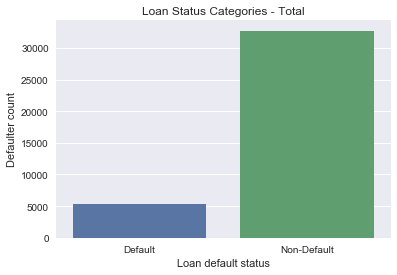

In [13]:
# Bar chart for Loan Status categories
sns.set(style="darkgrid")
barplot=sns.barplot(x='loan_status_cat', y='loan_amnt', data=cat_total, estimator=np.sum, linewidth=5)
barplot.set(title='Loan Status Categories - Total', xlabel='Loan default status', ylabel='Defaulter count')
plt.show()

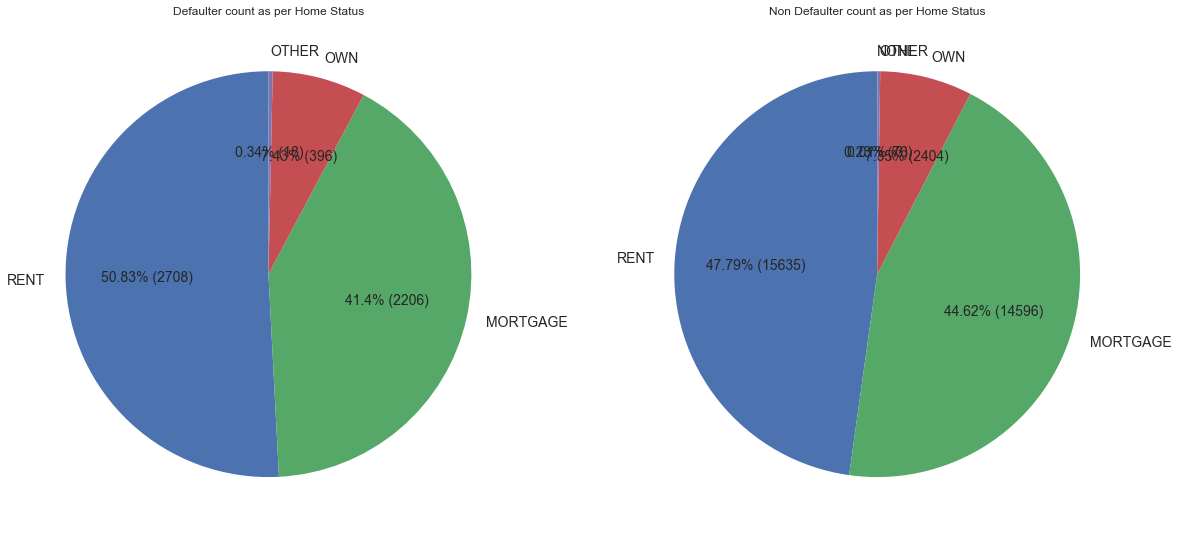

In [14]:
# Pie charts for defaulter count as per Home Ownership
def pie_label_home_ownership_def(val):
    return ("{0}% ({1})".format(round(val,2), 
                                int(round((val/100) * home_status_sort['def']['loan_amnt'].sum()))))
def pie_label_home_ownership_nondef(val):
    return ("{0}% ({1})".format(round(val,2), 
                                int(round((val/100) * home_status_sort['non-def']['loan_amnt'].sum()))))

sns.set(style="darkgrid")
plt.figure(figsize=(20,20))

ax1 = plt.subplot(121, aspect='equal')
plot121 = home_status_sort['def'].plot(kind='pie', y = 'loan_amnt', ax=ax1, autopct=pie_label_home_ownership_def, 
 startangle=90, shadow=False, labels=home_status_sort['def']['home_ownership'], legend = False, fontsize=14)
plot121.set(title='Defaulter count as per Home Status', ylabel="")

ax1 = plt.subplot(122, aspect='equal')
plot122 = home_status_sort['non-def'].plot(kind='pie', y = 'loan_amnt', ax=ax1, autopct=pie_label_home_ownership_nondef, 
 startangle=90, shadow=False, labels=home_status_sort['non-def']['home_ownership'], legend = False, fontsize=14)
plot122.set(title='Non Defaulter count as per Home Status', ylabel="")

plt.show()

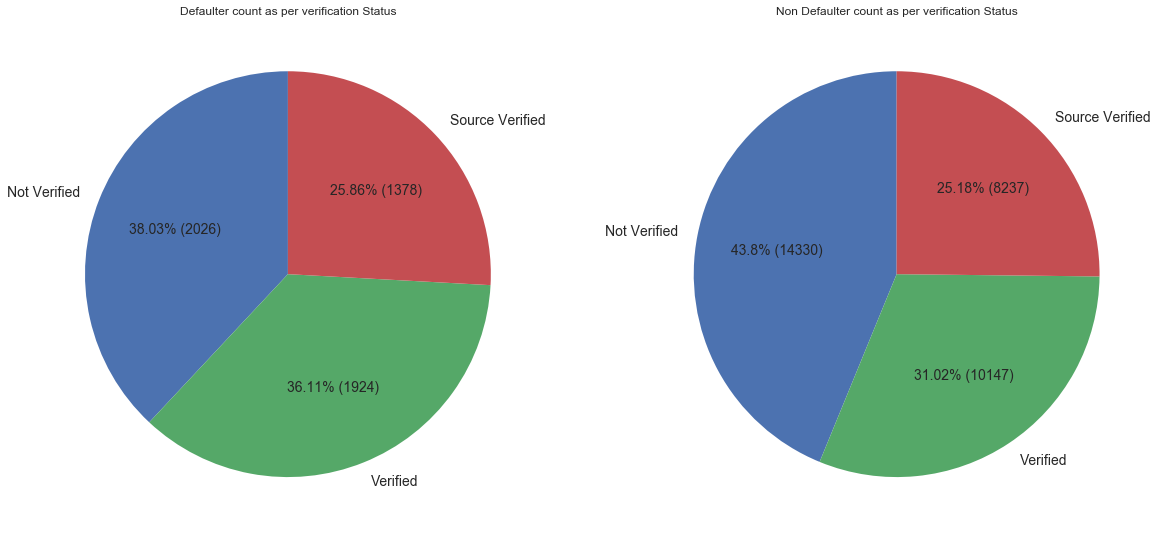

In [15]:
# Pie charts for defaulter count as per Verification status
def pie_label_verify_def(val):
    return ("{0}% ({1})".format(round(val,2), 
                                int(round((val/100) * verify_status_sort['def']['loan_amnt'].sum()))))
def pie_label_verify_nondef(val):
    return ("{0}% ({1})".format(round(val,2), 
                                int(round((val/100) * verify_status_sort['non-def']['loan_amnt'].sum()))))

sns.set(style="darkgrid")
plt.figure(figsize=(20,20))

ax1 = plt.subplot(121, aspect='equal')
plot121 = verify_status_sort['def'].plot(kind='pie', y = 'loan_amnt', ax=ax1, autopct=pie_label_verify_def, 
 startangle=90, shadow=False, labels=verify_status_sort['def']['verification_status'], legend = False, fontsize=14)
plot121.set(title='Defaulter count as per verification Status', ylabel="")

ax2 = plt.subplot(122, aspect='equal')
plot122 = verify_status_sort['non-def'].plot(kind='pie', y = 'loan_amnt', ax=ax2, autopct=pie_label_verify_nondef, 
 startangle=90, shadow=False, labels=verify_status_sort['non-def']['verification_status'], legend = False, fontsize=14)
plot122.set(title='Non Defaulter count as per verification Status', ylabel="")

plt.show()

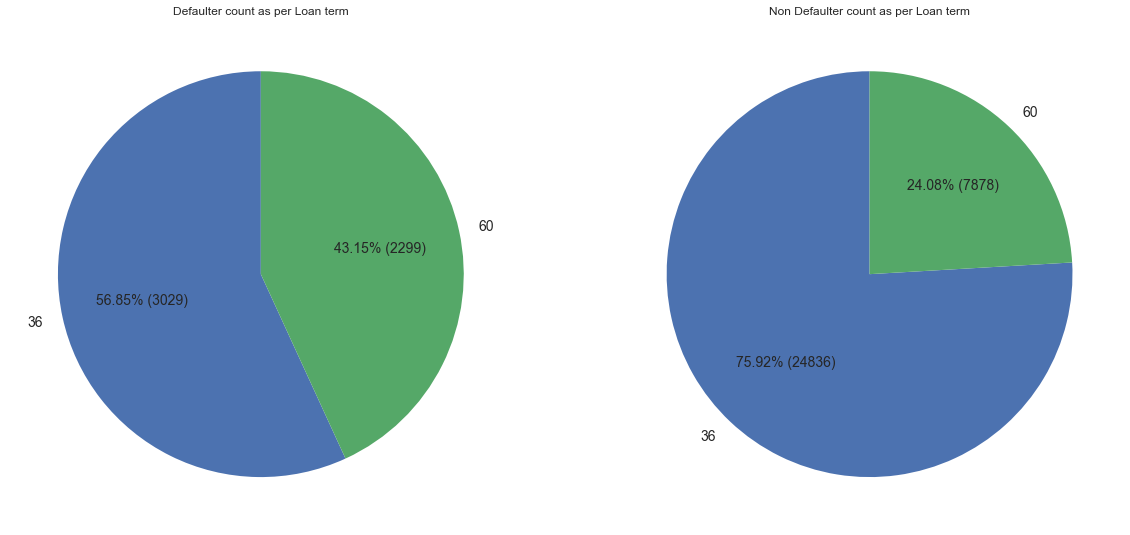

In [16]:
# Pie charts for Loan Term
def pie_label_loan_term_def(val):
    return ("{0}% ({1})".format(round(val,2), 
                                int(round((val/100) * term_status_sort['def']['loan_amnt'].sum()))))
def pie_label_loan_term_nondef(val):
    return ("{0}% ({1})".format(round(val,2), 
                                int(round((val/100) * term_status_sort['non-def']['loan_amnt'].sum()))))

sns.set(style="darkgrid")
plt.figure(figsize=(20,20))

ax1 = plt.subplot(121, aspect='equal')
plot121 = term_status_sort['def'].plot(kind='pie', y = 'loan_amnt', ax=ax1, autopct=pie_label_loan_term_def, 
 startangle=90, shadow=False, labels=term_status_sort['def']['term'], legend = False, fontsize=14)
plot121.set(title='Defaulter count as per Loan term', ylabel="")

ax2 = plt.subplot(122, aspect='equal')
plot122 = term_status_sort['non-def'].plot(kind='pie', y = 'loan_amnt', ax=ax2, autopct=pie_label_loan_term_nondef, 
 startangle=90, shadow=False, labels=term_status_sort['non-def']['term'], legend = False, fontsize=14)
plot122.set(title='Non Defaulter count as per Loan term', ylabel="")

plt.show()

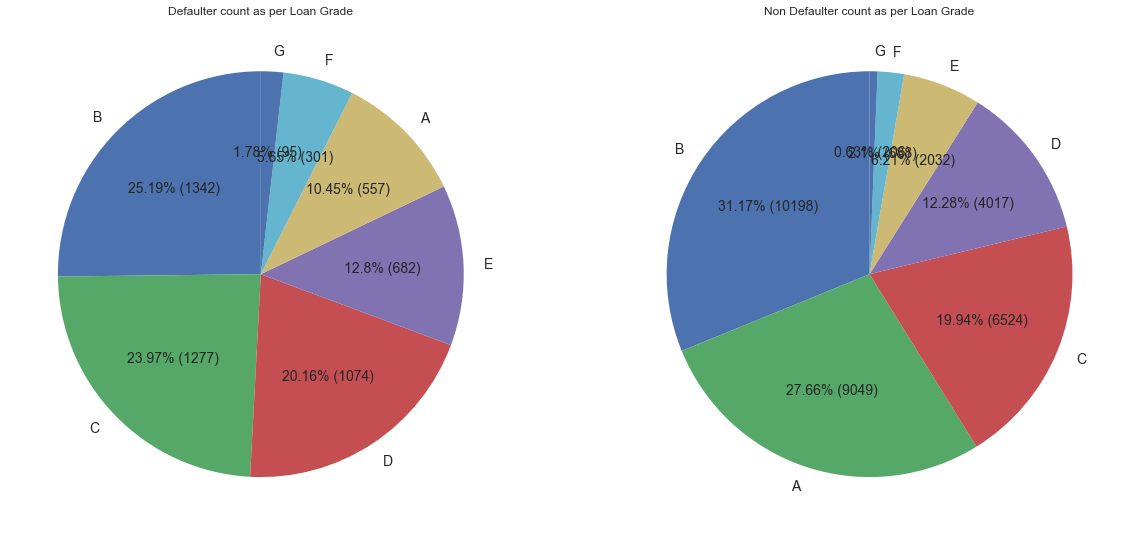

In [17]:
# Pie charts for defaulter count as per Loan grade
def pie_label_loan_grade_def(val):
    return ("{0}% ({1})".format(round(val,2), 
                                int(round((val/100) * grade_status_sort['def']['loan_amnt'].sum()))))
def pie_label_loan_grade_nondef(val):
    return ("{0}% ({1})".format(round(val,2), 
                                int(round((val/100) * grade_status_sort['non-def']['loan_amnt'].sum()))))

sns.set(style="darkgrid")
plt.figure(figsize=(20,20))

ax1 = plt.subplot(121, aspect='equal')
plot121 = grade_status_sort['def'].plot(kind='pie', y = 'loan_amnt', ax=ax1, autopct=pie_label_loan_grade_def, 
 startangle=90, shadow=False, labels=grade_status_sort['def']['grade'], legend = False, fontsize=14)
plot121.set(title='Defaulter count as per Loan Grade', ylabel="")
ax2 = plt.subplot(122, aspect='equal')
plot122 = grade_status_sort['non-def'].plot(kind='pie', y = 'loan_amnt', ax=ax2, autopct=pie_label_loan_grade_nondef, 
 startangle=90, shadow=False, labels=grade_status_sort['non-def']['grade'], legend = False, fontsize=14)
plot122.set(title='Non Defaulter count as per Loan Grade', ylabel="")

plt.show()

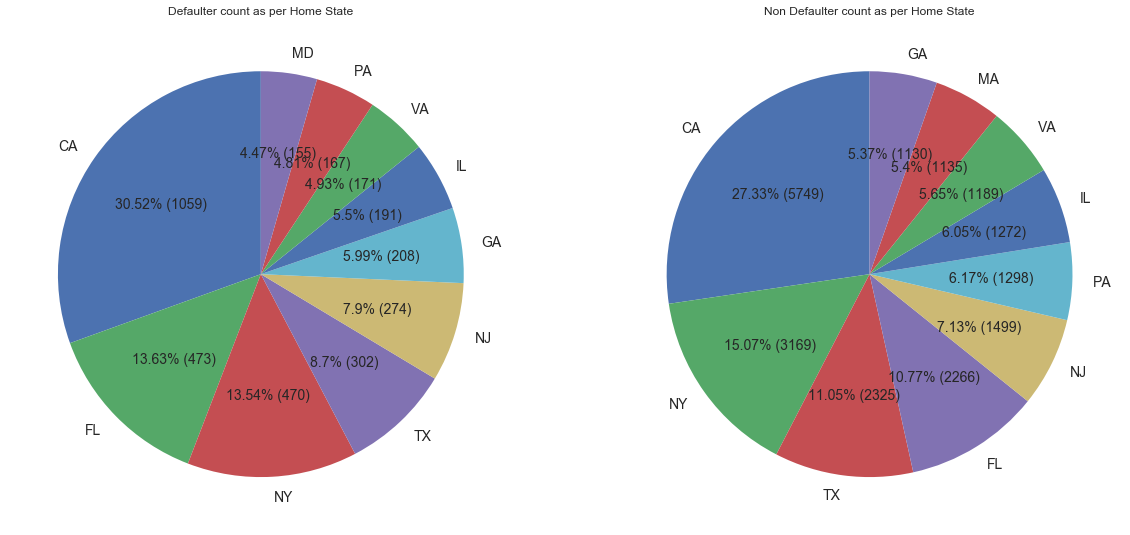

In [18]:
# Pie chart for state wise count
def get_wo_outliers(df, dfcol, ratio):
    return (df[df[dfcol] > df[dfcol].quantile(ratio)])

def pie_label_state_def(val):
    return ("{0}% ({1})".format(round(val,2), int(
        round((val/100) * get_wo_outliers(state_status_sort['def'],'loan_amnt', 0.80)['loan_amnt'].sum()))))
def pie_label_state_nondef(val):
    return ("{0}% ({1})".format(round(val,2), int(
        round((val/100) * get_wo_outliers(state_status_sort['non-def'],'loan_amnt', 0.80)['loan_amnt'].sum()))))

sns.set(style="darkgrid")
plt.figure(figsize=(20,20))

ax1 = plt.subplot(121, aspect='equal')
plot121 = get_wo_outliers(state_status_sort['def'],'loan_amnt', 0.80).plot(
    kind='pie', y = 'loan_amnt',  ax = ax1, autopct=pie_label_state_def, 
    startangle=90, shadow=False, labels=state_status_sort['def']['addr_state'], legend = False, fontsize=14)
plot121.set(title='Defaulter count as per Home State', ylabel="")

ax2 = plt.subplot(122, aspect='equal')
plot122 = get_wo_outliers(state_status_sort['non-def'],'loan_amnt', 0.80).plot(
    kind='pie', y = 'loan_amnt',  ax = ax2, autopct=pie_label_state_nondef, 
    startangle=90, shadow=False, labels=state_status_sort['non-def']['addr_state'], legend = False, fontsize=14)
plot122.set(title='Non Defaulter count as per Home State', ylabel="")

plt.show()

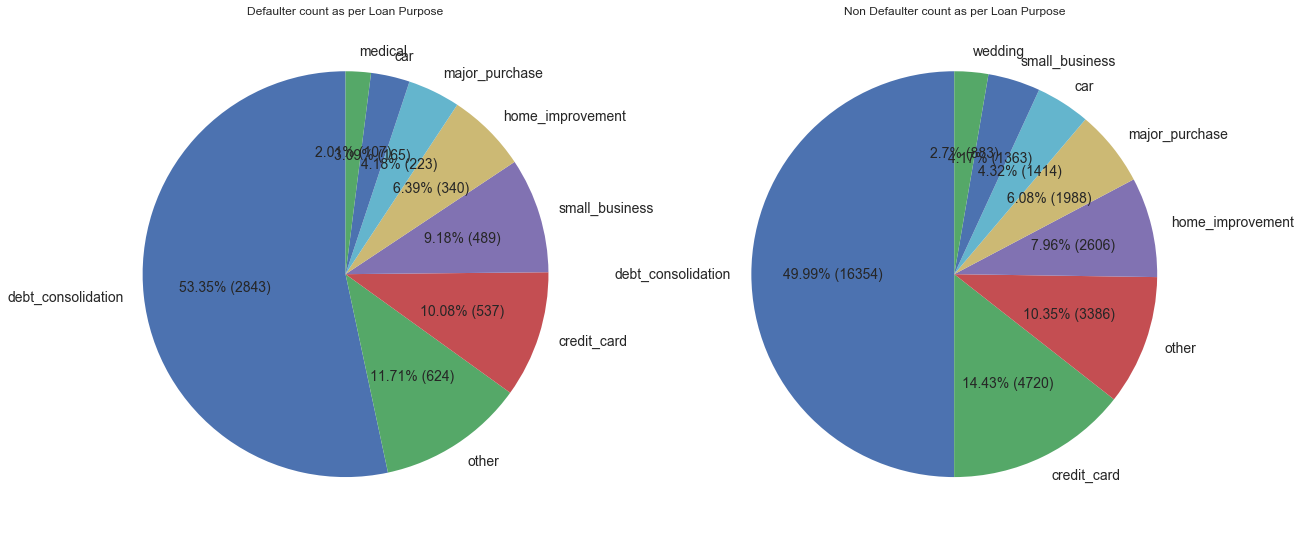

In [19]:
# Pie chart for loan purpose
def pie_label_purpose_def(val):
    return ("{0}% ({1})".format(round(val,2), 
                                int(round((val/100) * purpose_status_sort['def']['loan_amnt'].sum()))))
def pie_label_purpose_nondef(val):
    return ("{0}% ({1})".format(round(val,2), 
                                int(round((val/100) * purpose_status_sort['non-def']['loan_amnt'].sum()))))

sns.set(style="darkgrid")
plt.figure(figsize=(20,20))

ax1 = plt.subplot(121, aspect='equal')
data_wo_outliers = get_wo_outliers(purpose_status_sort['def'],'loan_amnt',0.40)
plot121 = data_wo_outliers.plot(kind='pie', y = 'loan_amnt', ax=ax1, autopct=pie_label_purpose_def, 
 startangle=90, shadow=False, labels=data_wo_outliers['purpose'], legend = False, fontsize=14)
plot121.set(title='Defaulter count as per Loan Purpose', ylabel="")

ax1 = plt.subplot(122, aspect='equal')
data_wo_outliers = get_wo_outliers(purpose_status_sort['non-def'],'loan_amnt',0.40)
plot121 = data_wo_outliers.plot(kind='pie', y = 'loan_amnt', ax=ax1, autopct=pie_label_purpose_nondef, 
 startangle=90, shadow=False, labels=data_wo_outliers['purpose'], legend = False, fontsize=14)
plot121.set(title='Non Defaulter count as per Loan Purpose', ylabel="")

plt.show()

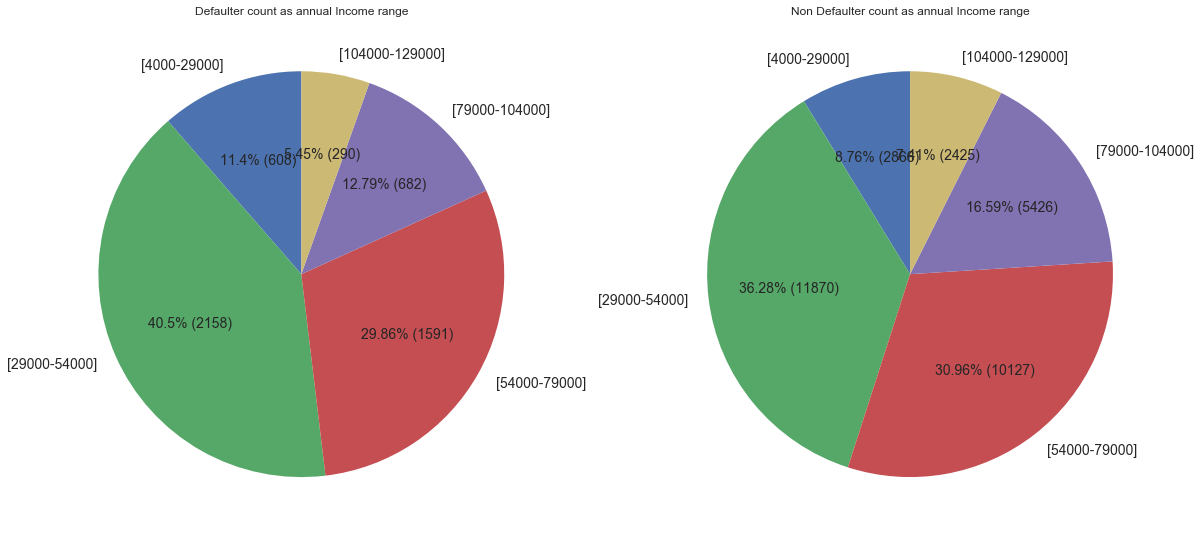

In [20]:
def pie_label_income_def(val):
    return ("{0}% ({1})".format(round(val,2), 
                                int(round((val/100) * income_status_sort['def']['annual_inc'].sum()))))
def pie_label_income_nondef(val):
    return ("{0}% ({1})".format(round(val,2), 
                                int(round((val/100) * income_status_sort['non-def']['annual_inc'].sum()))))

sns.set(style="darkgrid")
plt.figure(figsize=(20,20))

ax1 = plt.subplot(121, aspect='equal')
data_wo_outliers = get_wo_outliers(income_status_sort['def'], 'annual_inc',0.40)
plot121 = data_wo_outliers.plot(kind='pie', y = 'annual_inc', ax=ax1, autopct=pie_label_income_def, 
 startangle=90, shadow=False, labels=data_wo_outliers['annual_inc_bin'], legend = False, fontsize=14)
plot121.set(title='Defaulter count as annual Income range', ylabel="")

ax2 = plt.subplot(122, aspect='equal')
data_wo_outliers = get_wo_outliers(income_status_sort['non-def'], 'annual_inc',0.40)
plot122 = data_wo_outliers.plot(kind='pie', y = 'annual_inc', ax=ax2, autopct=pie_label_income_nondef, 
 startangle=90, shadow=False, labels=data_wo_outliers['annual_inc_bin'], legend = False, fontsize=14)
plot122.set(title='Non Defaulter count as annual Income range', ylabel="")

plt.show()

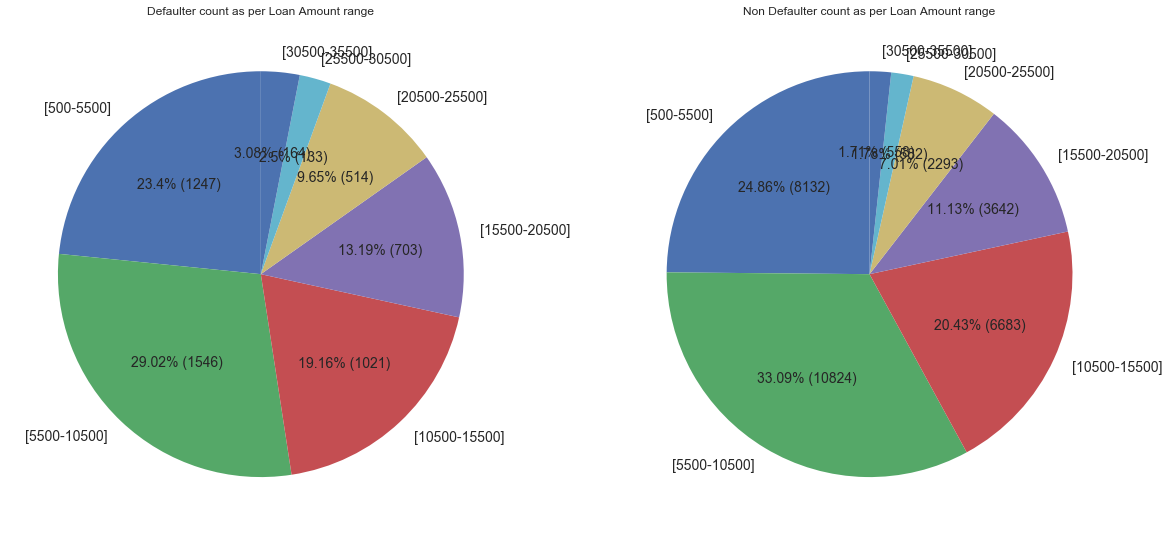

In [21]:
# Pie chart of defaulter count for Loan amount
def pie_label_amount_def(val):
    return ("{0}% ({1})".format(round(val,2), 
                                int(round((val/100) * loan_amnt_sort['def']['loan_amnt'].sum()))))
def pie_label_amount_nondef(val):
    return ("{0}% ({1})".format(round(val,2), 
                                int(round((val/100) * loan_amnt_sort['non-def']['loan_amnt'].sum()))))

sns.set(style="darkgrid")
plt.figure(figsize=(20,20))

ax1 = plt.subplot(121, aspect='equal')
plot121 = loan_amnt_sort['def'].plot(kind='pie', y = 'loan_amnt', ax=ax1, autopct=pie_label_amount_def, 
 startangle=90, shadow=False, labels=loan_amnt_sort['def']['loan_amnt_bin'], legend = False, fontsize=14)
plot121.set(title='Defaulter count as per Loan Amount range', ylabel="")

ax2 = plt.subplot(122, aspect='equal')
plot122 = loan_amnt_sort['non-def'].plot(kind='pie', y = 'loan_amnt', ax=ax2, autopct=pie_label_amount_nondef, 
 startangle=90, shadow=False, labels=loan_amnt_sort['non-def']['loan_amnt_bin'], legend = False, fontsize=14)
plot122.set(title='Non Defaulter count as per Loan Amount range', ylabel="")

plt.show()

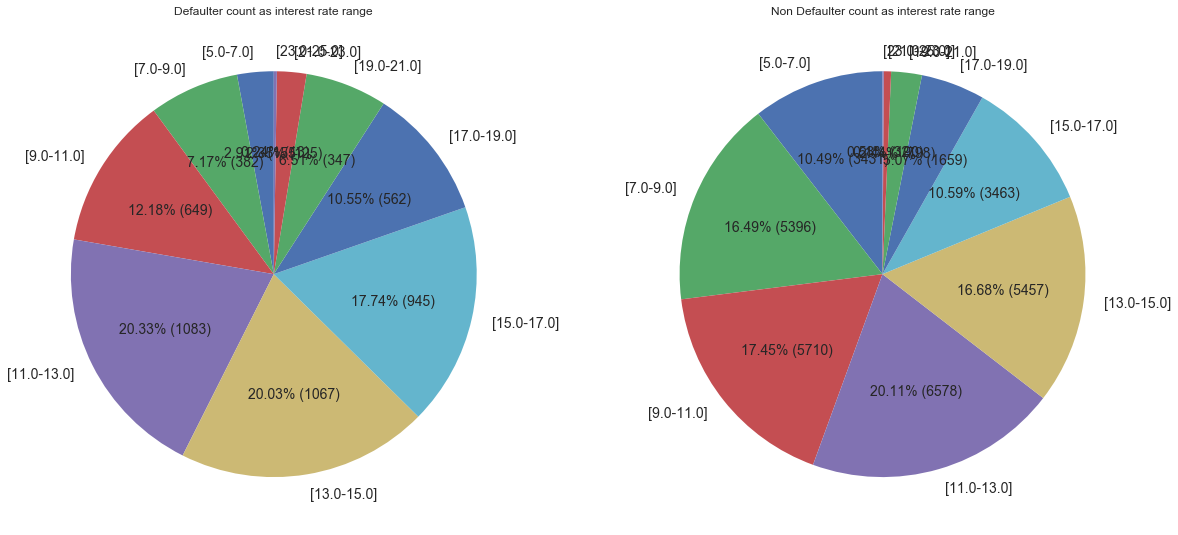

In [22]:
# Pie chart of defaulter count for Interest Rate
def pie_label_interest_def(val):
    return ("{0}% ({1})".format(round(val,2), 
                                int(round((val/100) * int_status_sort['def']['int_rate'].sum()))))
def pie_label_interest_nondef(val):
    return ("{0}% ({1})".format(round(val,2), 
                                int(round((val/100) * int_status_sort['non-def']['int_rate'].sum()))))

sns.set(style="darkgrid")
plt.figure(figsize=(20,20))

ax1 = plt.subplot(121, aspect='equal')
plot121 = int_status_sort['def'].plot(kind='pie', y = 'int_rate', ax=ax1, autopct=pie_label_interest_def, 
 startangle=90, shadow=False, labels=int_status_sort['def']['int_rate_bin'], legend = False, fontsize=14)
plot121.set(title='Defaulter count as interest rate range', ylabel="")

ax2 = plt.subplot(122, aspect='equal')
plot122 = int_status_sort['non-def'].plot(kind='pie', y = 'int_rate', ax=ax2, autopct=pie_label_interest_nondef, 
 startangle=90, shadow=False, labels=int_status_sort['non-def']['int_rate_bin'], legend = False, fontsize=14)
plot122.set(title='Non Defaulter count as interest rate range', ylabel="")

plt.show()

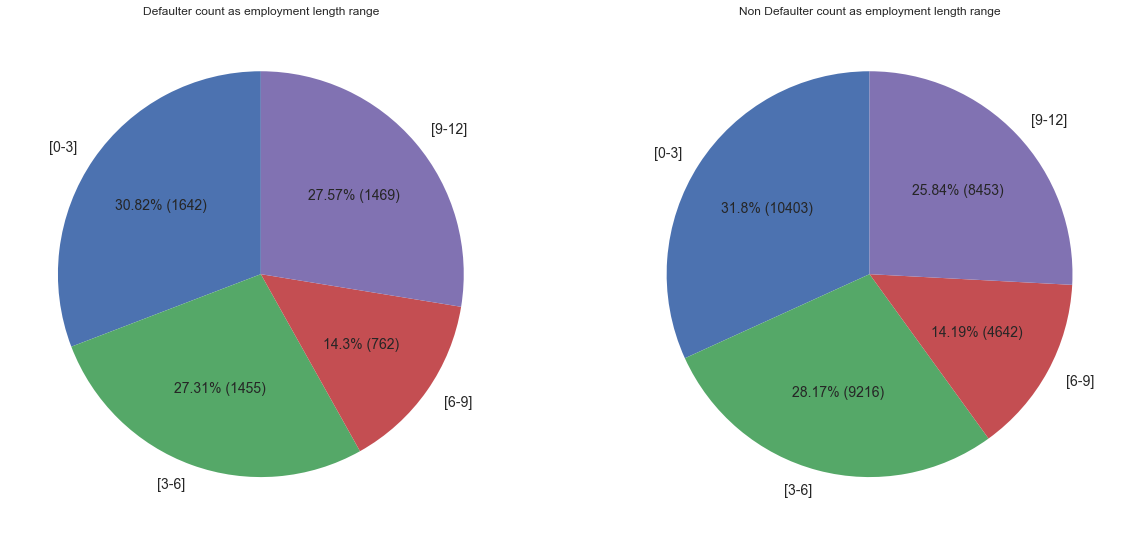

In [23]:
# Pie chart of defaulter count for Employment Length
def pie_label_emplen_def(val):
    return ("{0}% ({1})".format(round(val,2), 
                                int(round((val/100) * emplen_status_sort['def']['emp_length'].sum()))))
def pie_label_emplen_nondef(val):
    return ("{0}% ({1})".format(round(val,2), 
                                int(round((val/100) * emplen_status_sort['non-def']['emp_length'].sum()))))

sns.set(style="darkgrid")
plt.figure(figsize=(20,20))

ax1 = plt.subplot(121, aspect='equal')
plot121 = emplen_status_sort['def'].plot(kind='pie', y = 'emp_length', ax=ax1, autopct=pie_label_emplen_def, 
 startangle=90, shadow=False, labels=emplen_status_sort['def']['emp_length_bin'], legend = False, fontsize=14)
plot121.set(title='Defaulter count as employment length range', ylabel="")

ax2 = plt.subplot(122, aspect='equal')
plot122 = emplen_status_sort['non-def'].plot(kind='pie', y = 'emp_length', ax=ax2, autopct=pie_label_emplen_nondef, 
 startangle=90, shadow=False, labels=emplen_status_sort['non-def']['emp_length_bin'], legend = False, fontsize=14)
plot122.set(title='Non Defaulter count as employment length range', ylabel="")

plt.show()

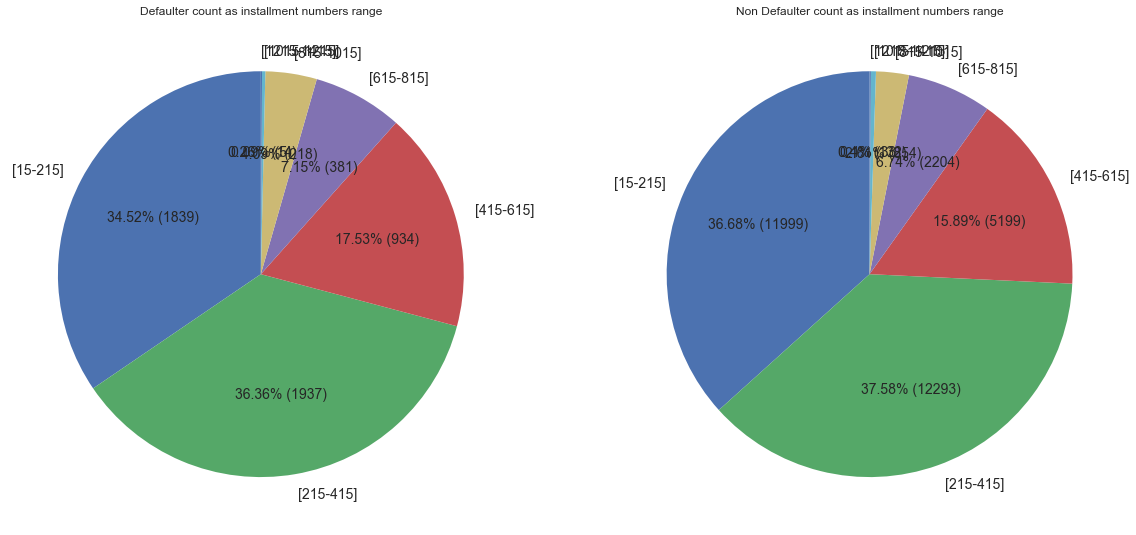

In [24]:
# Pie chart of defaulter count for Installment numbers
def pie_label_installment_def(val):
    return ("{0}% ({1})".format(round(val,2), 
                                int(round((val/100) * instal_status_sort['def']['installment'].sum()))))
def pie_label_installment_nondef(val):
    return ("{0}% ({1})".format(round(val,2), 
                                int(round((val/100) * instal_status_sort['non-def']['installment'].sum()))))

sns.set(style="darkgrid")
plt.figure(figsize=(20,20))

ax1 = plt.subplot(121, aspect='equal')
plot121 = instal_status_sort['def'].plot(kind='pie', y = 'installment', ax=ax1, autopct=pie_label_installment_def, 
 startangle=90, shadow=False, labels=instal_status_sort['def']['installment_bin'], legend = False, fontsize=14)
plot121.set(title='Defaulter count as installment numbers range', ylabel="")

ax2 = plt.subplot(122, aspect='equal')
plot122 = instal_status_sort['non-def'].plot(kind='pie', y = 'installment', ax=ax2, autopct=pie_label_installment_nondef, 
 startangle=90, shadow=False, labels=instal_status_sort['non-def']['installment_bin'], legend = False, fontsize=14)
plot122.set(title='Non Defaulter count as installment numbers range', ylabel="")

plt.show()

# Frequency/Density visualizations of Individual columns for defaulters (Univariate Analysis)
Note: Warning [The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.] cannot be avoided as seaborn has not yet incorporated it in their stable release. https://github.com/mwaskom/seaborn/issues/1392

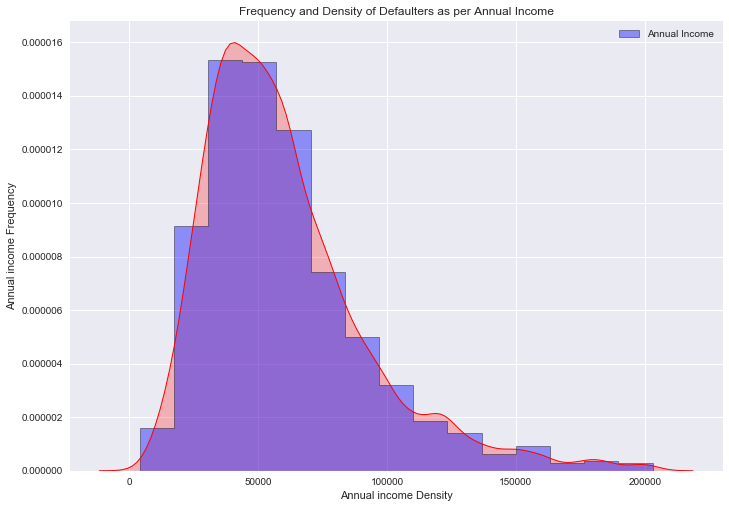

In [25]:
#Frequency and density plot for defaulter counts as per Annual Income
sns.set(rc={'figure.figsize':(11.7,8.27)})
barplot=sns.distplot(loan_def['annual_inc'], hist=True, bins=15, label='Annual Income', kde=True,
             kde_kws = {'shade': True, 'linewidth': 1,'color': "r"},
             hist_kws = {"histtype": "stepfilled", "linewidth": 1,"alpha": 0.4, "color": "b","edgecolor":"black"})
barplot.set(title="Frequency and Density of Defaulters as per Annual Income", 
            xlabel="Annual income Density", ylabel="Annual income Frequency")
plt.legend()


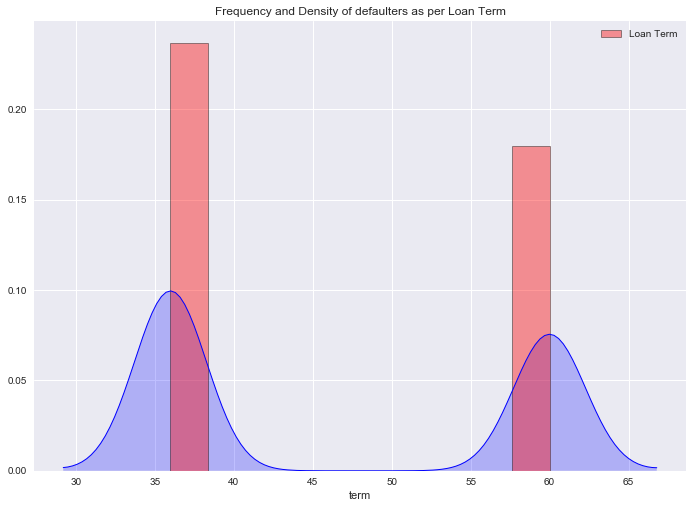

In [26]:
#Frequency and density plot for defaulters as per Loan Term
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.title("Frequency and Density of defaulters as per Loan Term")
loan_def['term'] = loan_def['term'].astype(int)
sns.distplot(loan_def['term'], hist=True, bins=10, label='Loan Term',
             kde_kws = {'shade': True, 'linewidth': 1,'color': "b"},
             hist_kws={"histtype": "stepfilled", "linewidth": 1,"alpha": 0.4, "color": "r","edgecolor":"black"})
plt.legend()

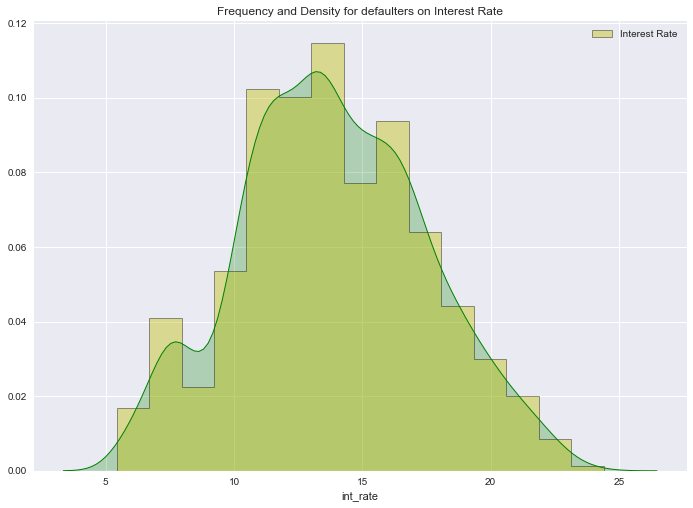

In [27]:
#Frequency and density plot for defaulters on Interest Rate
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.title("Frequency and Density for defaulters on Interest Rate")
sns.distplot(loan_def['int_rate'], hist=True,bins=15,label='Interest Rate',
             kde_kws = {'shade': True, 'linewidth': 1,'color': "g"},
             hist_kws={"histtype": "stepfilled", "linewidth": 1,"alpha": 0.4, "color": "y","edgecolor":"black"})
plt.legend()

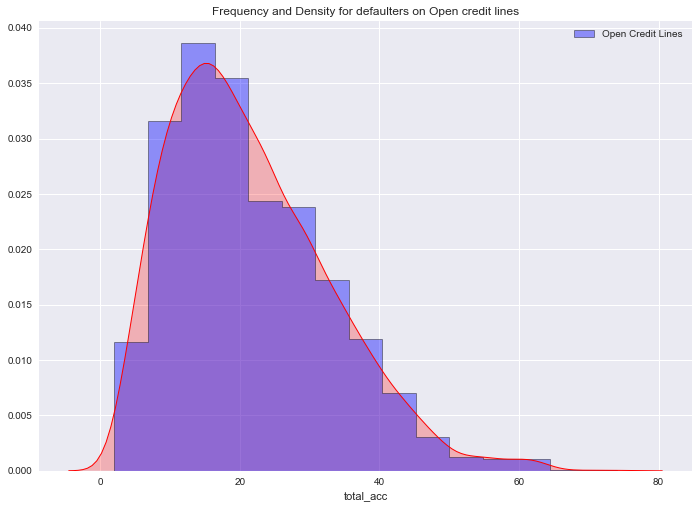

In [28]:
#Frequency and density plot for defaulters on Open credit lines
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.title("Frequency and Density for defaulters on Open credit lines")
sns.distplot(loan_def['total_acc'], hist=True,bins=15,label='Open Credit Lines',
             kde_kws = {'shade': True, 'linewidth': 1,'color': "r"},
             hist_kws={"histtype": "stepfilled", "linewidth": 1,"alpha": 0.4, "color": "b","edgecolor":"black"})
plt.legend()

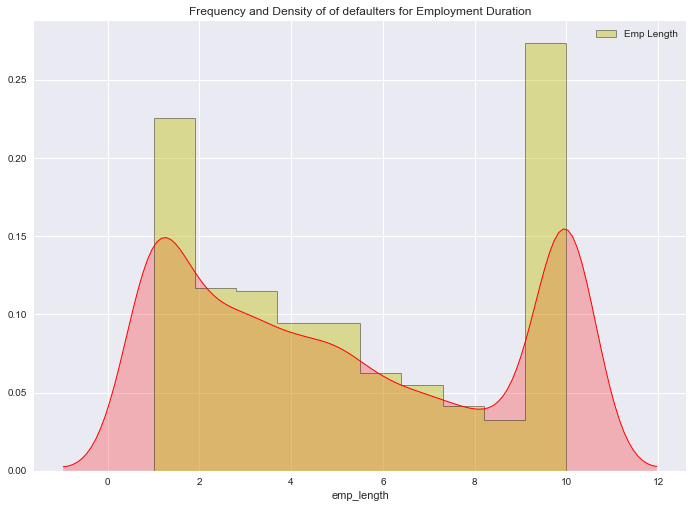

In [29]:
#Frequency and density plot of defaulters for Employment length
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.title("Frequency and Density of of defaulters for Employment Duration")
sns.distplot(loan_def['emp_length'], hist=True,bins=10,label='Emp Length',
             kde_kws = {'shade': True, 'linewidth': 1,'color': "r"},
             hist_kws={"histtype": "stepfilled", "linewidth": 1,"alpha": 0.4, "color": "y","edgecolor":"black"})
plt.legend()

# Box, Histogram and Density plots for Univariate Analysis

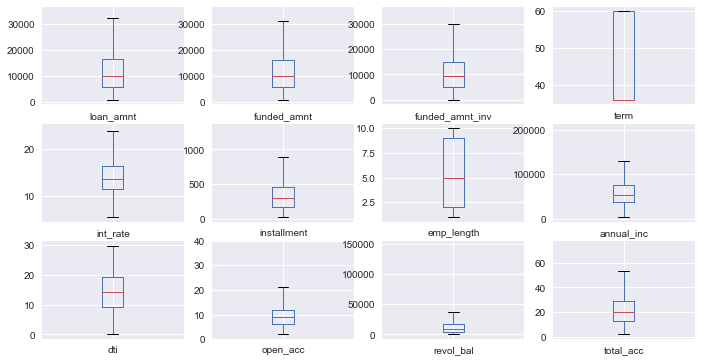

In [30]:
# Boxplot Matrix for numberic variables -
# loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,open_acc,revol_bal,total_acc
names = ['loan_amnt','funded_amnt','funded_amnt_inv','int_rate','installment',
         'annual_inc','dti','open_acc','revol_bal','total_acc']
loan_corre = loan_def.filter(['loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate',
                              'installment','emp_length','annual_inc','dti','open_acc',
                              'revol_bal','total_acc','all_util'], axis=1)
loan_corre.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False)
plt.show()

# Distribution Skewness Analysis

We will only consider the numerical variables that are found suitable as per the comparative analysis

For columns - annual_inc, term, int_rate, total_acc, emp_len

In [31]:
# Distribution Skewness analysis for-loan_amnt,int_rate,annual_inc,dti,revol_bal,total_acc,emp_length and installment
print('Annual Income Distribution Skew =', loan_def['annual_inc'].skew())
print('Interest Rate Distribution Skew =', loan_def['int_rate'].skew())
print('Loan Term Distribution Skew =', loan_def['term'].skew())
print('Total open credit lines Distribution Skew =', loan_def['total_acc'].skew())
print('Employment length Distribution Skew =', loan_def['emp_length'].skew())

Annual Income Distribution Skew = 1.374186787025546
Interest Rate Distribution Skew = 0.0925653554186973
Loan Term Distribution Skew = 0.2767107504551929
Total open credit lines Distribution Skew = 0.8023170099688735
Employment length Distribution Skew = 0.25339400991372213


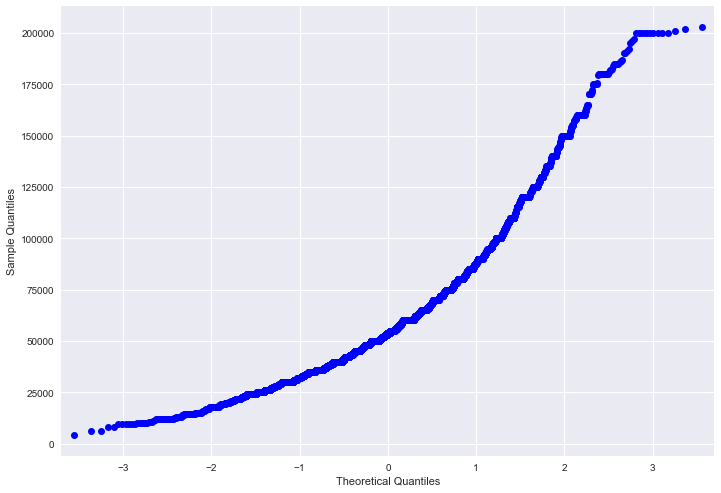

In [32]:
# Distribution qqplot for annual_income
plt.figure(figsize=(15,10))
sm.qqplot(loan_def.annual_inc)
plt.show()

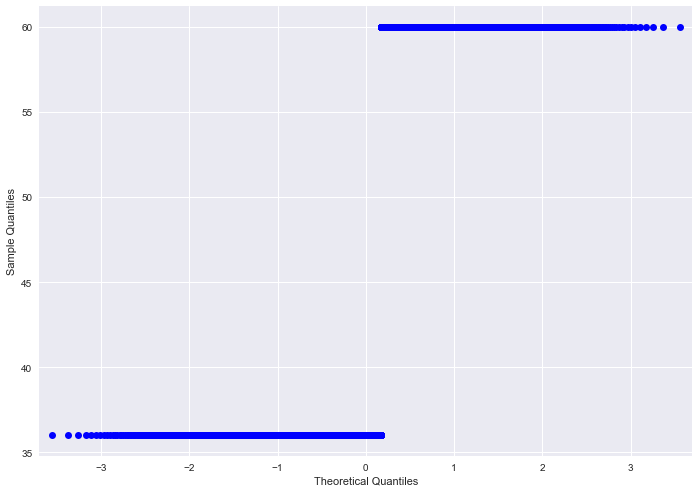

In [33]:
# Distribution qqplot for term
plt.figure(figsize=(15,10))
sm.qqplot(loan_def.term)
plt.show()

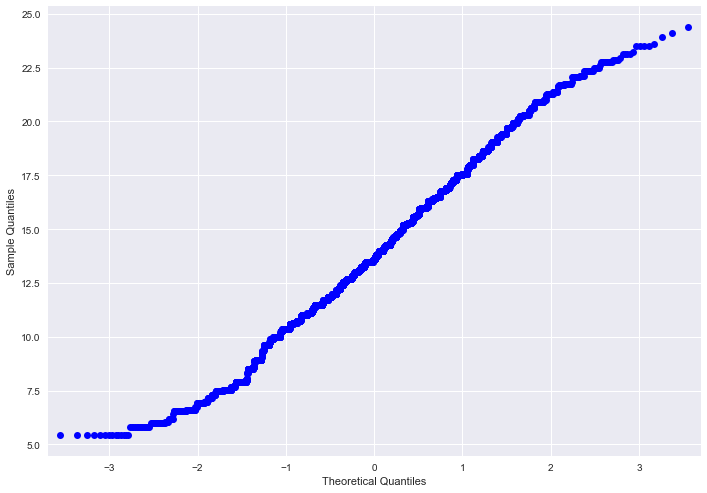

In [34]:
# Distribution qqplot for int_rate
plt.figure(figsize=(15,10))
sm.qqplot(loan_def.int_rate)
plt.show()

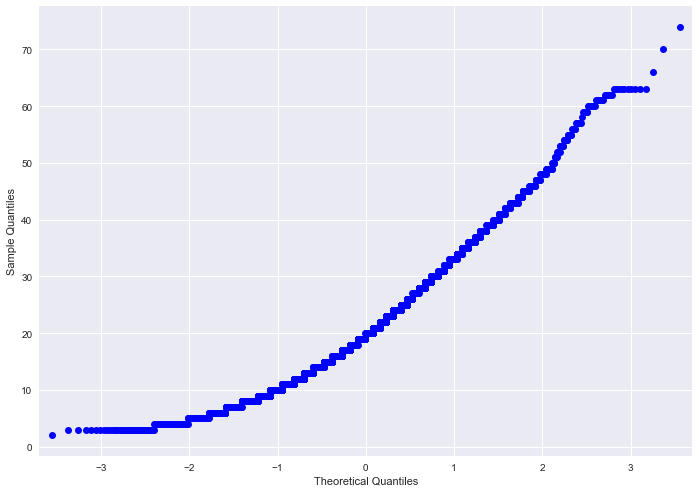

In [35]:
# Distribution qqplot for total_acc
plt.figure(figsize=(15,10))
sm.qqplot(loan_def.total_acc)
plt.show()

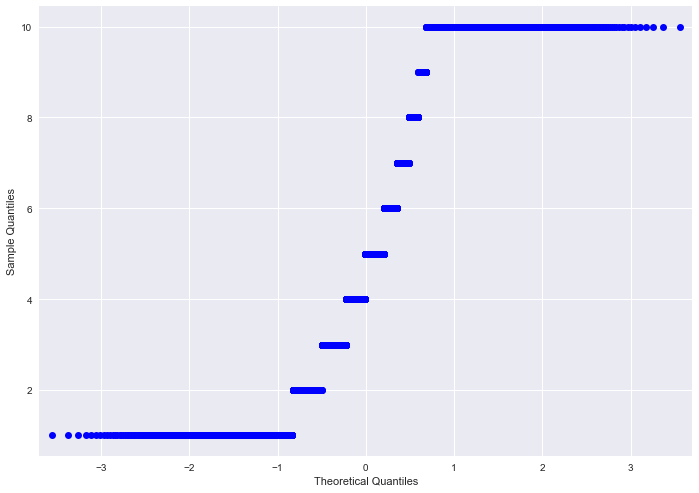

In [36]:
# Distribution qqplot for emp_length
plt.figure(figsize=(15,10))
sm.qqplot(loan_def.emp_length)
plt.show()

# Multivariate Analysis - Correlation Data and Plot

Correlation matrix table and plot for the columns - 

'loan_amnt', 'term', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'total_acc'

In [37]:
# Correction Matrix Table for numeric fields
# 'loan_amnt','term','int_rate','installment','emp_length','annual_inc','total_acc'

loan_corre = loan_def.filter(['loan_amnt','term','int_rate','installment','emp_length','annual_inc',
                              'total_acc'], axis=1)
corr = loan_corre.corr()
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    """ Magnify the result when hovered upon """
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())


,loan_amnt,term,int_rate,installment,emp_length,annual_inc,total_acc
loan_amnt,1,0.39,0.35,0.92,0.19,0.45,0.27
term,0.39,1,0.46,0.13,0.14,0.11,0.12
int_rate,0.35,0.46,1,0.32,0.04,0.16,-0.016
installment,0.92,0.13,0.32,1,0.16,0.45,0.24
emp_length,0.19,0.14,0.04,0.16,1,0.19,0.18
annual_inc,0.45,0.11,0.16,0.45,0.19,1,0.38
total_acc,0.27,0.12,-0.016,0.24,0.18,0.38,1


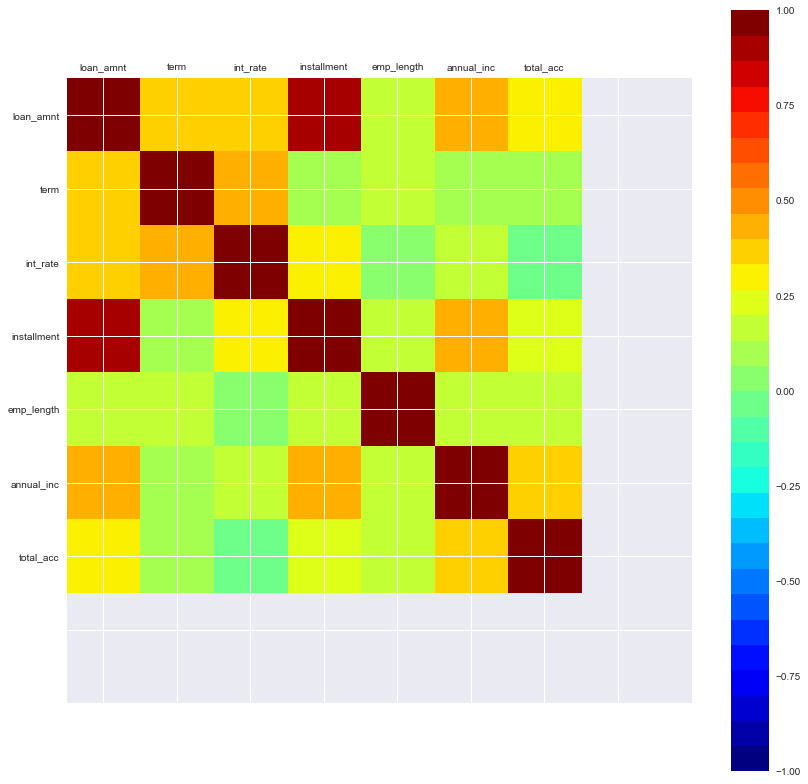

In [38]:
# Correction Matrix Plot for numeric fields
import numpy
correlations = loan_corre.corr()
names = ['loan_amnt','term','int_rate','installment','emp_length','annual_inc', 'total_acc']

plt.rcParams['figure.figsize']=(14,14)
fig = plt.figure()
ax = fig.add_subplot(111)
cmap = cm.get_cmap('jet', 30)
cax = ax.matshow(correlations, vmin=-1, vmax=1,cmap=cmap)
fig.colorbar(cax,drawedges=1,spacing='fixed')
ticks = numpy.arange(0,9,1)

ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)

plt.show()

# Compare summary statistics across two categories for defaulters (Bivariate)

Loan grade vs average int_rate

Loan grade vs Annual income

Loan purpose vs Annual income

Loan purpose vs Interest rate

Annual income vs Interest rate

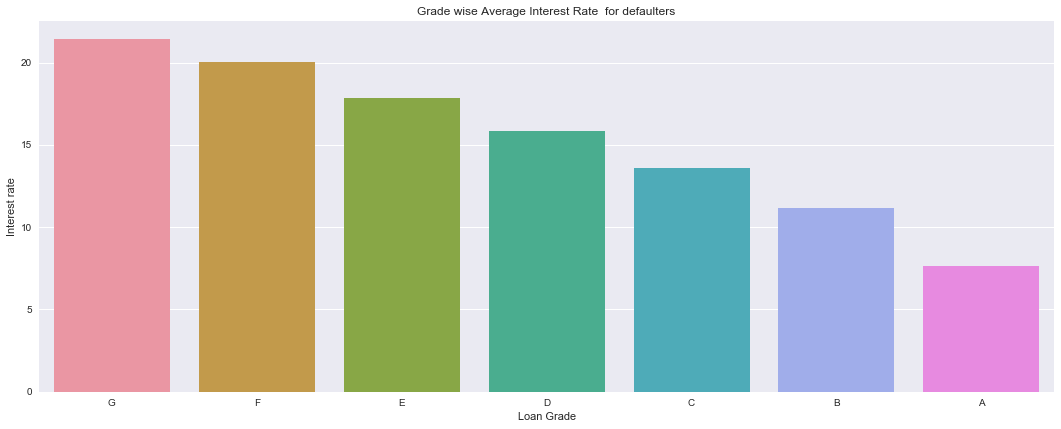

In [39]:
# Compare summary stats for Loan grade vs average int_rate for defaulters
sns.set(style="darkgrid")
plt.figure(figsize=(40,15))

plt.subplot(221)
barplot=sns.barplot(x='grade', y='int_rate', data=gradeint_status_sort['def'])
barplot.set(title='Grade wise Average Interest Rate  for defaulters', xlabel="Loan Grade", ylabel="Interest rate")
plt.show()

In [40]:
# Inference from the above plot
grade_int = loan_def.groupby(['grade'],as_index=False)
grade_int.int_rate.mean()

,grade,int_rate
0,A,7.636068
1,B,11.145395
2,C,13.600713
3,D,15.829246
4,E,17.857449
5,F,20.042990
6,G,21.445053


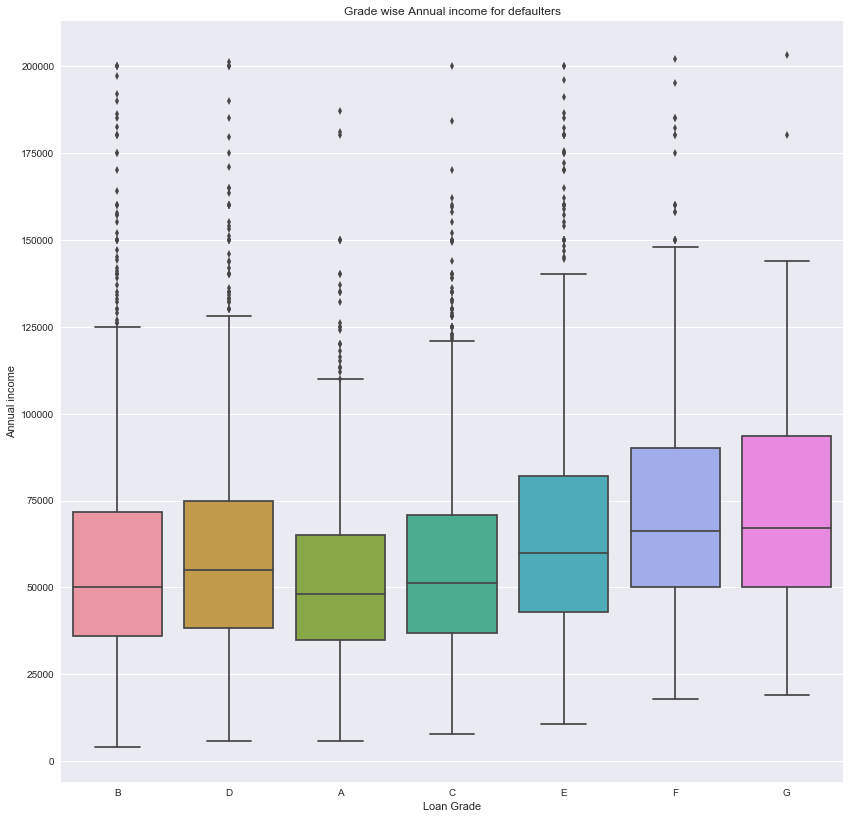

In [41]:
# Compare summary stats for Loan grade vs annual income for defaulters
sns.set(style="darkgrid")

boxplot=sns.boxplot(x='grade', y='annual_inc', data=loan_def)
boxplot.set(title='Grade wise Annual income for defaulters', xlabel="Loan Grade", ylabel="Annual income")
plt.show()

In [41]:
# Inference from the above plot
grade_inc = loan_def.groupby(['grade'],as_index=False)
grade_inc.annual_inc.median()

,grade,annual_inc
0,A,48000.00
1,B,50004.00
2,C,51170.00
3,D,54996.00
4,E,60000.00
5,F,66362.04
6,G,67032.00


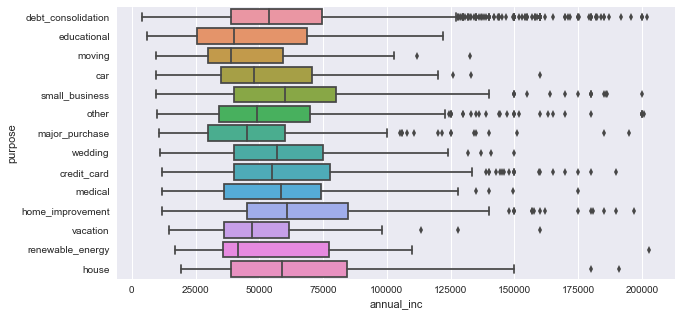

In [42]:
# Compare summary stats for Loan Purpose Vs annual Income for defaulters
plt.rcParams['figure.figsize']=(10,5)
sns.boxplot(y='purpose', x='annual_inc', data=loan_def)
plt.show()

In [43]:
# Inference from the above plot
purpose_annual_inc = loan_def.groupby(['purpose'],as_index=False)
purpose_annual_inc.annual_inc.median()

,purpose,annual_inc
0,car,48000.0
1,credit_card,55000.0
2,debt_consolidation,54000.0
3,educational,40000.0
4,home_improvement,60900.0
5,house,58800.0
6,major_purchase,45000.0
7,medical,58500.0
8,moving,39011.5
9,other,48996.0


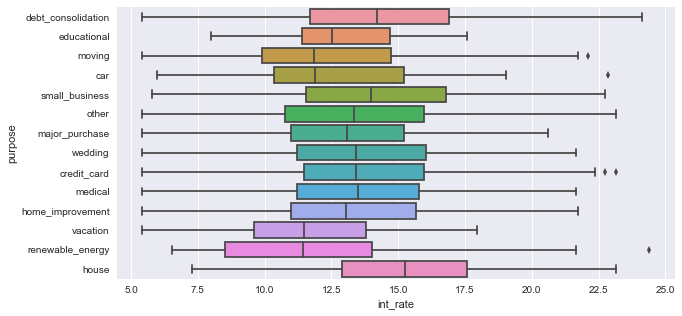

In [44]:
# Compare summary stats for Loan Purpose Vs Interest Rate for defaulters
plt.rcParams['figure.figsize']=(10,5)
sns.boxplot(y='purpose', x='int_rate', data=loan_def)
plt.show()

In [45]:
# Inference from the above plot
purpose_int_rate = loan_def.groupby(['purpose'],as_index=False)
purpose_int_rate.int_rate.median()

,purpose,int_rate
0,car,11.875
1,credit_card,13.430
2,debt_consolidation,14.220
3,educational,12.530
4,home_improvement,13.060
5,house,15.250
6,major_purchase,13.085
7,medical,13.490
8,moving,11.845
9,other,13.350


# Inferences derived from univariate and multivariate analysis for defaulters

In [53]:
# Inference derived from univariate analysis which will help in Risk Assessment
total_default_pct = round(100*(cat_total.loan_amnt[0]/cat_total.loan_amnt.sum()))
total_home_rent_pct = round(100*(home_status_sort['def'].loan_amnt[3])/home_status_sort['def'].loan_amnt.sum())
total_home_mort_pct = round(100*(home_status_sort['def'].loan_amnt[0])/home_status_sort['def'].loan_amnt.sum())
total_term_pct = round(100*(term_status_sort['def'].loan_amnt[0]/term_status_sort['def'].loan_amnt.sum()))
total_verif_pct = round(100*(verify_status_sort['def'].loan_amnt[0]/verify_status_sort['def'].loan_amnt.sum()))
total_state_pct = round(100*(state_status_sort['def'].loan_amnt[4]/state_status_sort['def'].loan_amnt.sum()))
total_grade_pct = round(100*(grade_status_sort['def'].loan_amnt[1]/grade_status_sort['def'].loan_amnt.sum()))
total_purpose_pct = round(100*(purpose_status_sort['def'].loan_amnt[2]/purpose_status_sort['def'].loan_amnt.sum()))
total_annincome_pct = round(100*(income_status_sort['def'].annual_inc[4]/income_status_sort['def'].annual_inc.sum()))
total_intrate_pct = round(100*
    ((int_status_sort['def'].int_rate[0] + int_status_sort['def'].int_rate[1])/int_status_sort['def'].int_rate.sum()))
total_ratio_pct = round(100*(
    (ratio_status_sort['def'].LtoI_ratio[1] + ratio_status_sort['def'].LtoI_ratio[2])/ratio_status_sort['def'].LtoI_ratio.sum()))
total_amt_pct = round(100*(
    (loan_amnt_sort['def'].loan_amnt[5] + loan_amnt_sort['def'].loan_amnt[6])/loan_amnt_sort['def'].loan_amnt.sum()))
total_emplen_pct = round(100*(
    (emplen_status_sort['def'].emp_length[0] + emplen_status_sort['def'].emp_length[1])/emplen_status_sort['def'].emp_length.sum()))
total_instal_pct = round(100*(
    (instal_status_sort['def'].installment[2] + instal_status_sort['def'].installment[5])/instal_status_sort['def'].installment.sum()))

print("Defaulters in the given dataset:\t\t\t{0}%".format(total_default_pct))
print("Defaulters having rented home:\t\t\t\t{0}%".format(total_home_rent_pct))
print("Defaulters having mortgaged home is:\t\t\t{0}%".format(total_home_mort_pct))
print("Defaulters having term of 36 months is:\t\t\t{0}%".format(total_term_pct))  
print("Defaulters who were not verified is:\t\t\t{0}%".format(total_verif_pct)) 
print("Defaulters in CA state is:\t\t\t\t{0}%".format(total_state_pct)) 
print("Defaulters for Grade B loantype is:\t\t\t{0}%".format(total_grade_pct)) 
print("Defaulters for the purpose of debt consolidation is:\t{0}%".format(total_purpose_pct)) 
print("Defaulters of annual income less than $104000 is:\t{0}%".format(total_annincome_pct)) 
print("Highest defaulters are between 11% to 15% interest rate: {0}%".format(total_intrate_pct)) 
print("Highest efaulters in the Loan to Income ratio between 10% to 30% is: {0}%".format(total_ratio_pct)) 
print("Defaulters who have taken a loan amount < $10500 is:\t{0}%".format(total_amt_pct)) 
print("Defaulters who have < 6 yrs of employment length is:\t{0}%".format(total_emplen_pct)) 
print("Defaulters who have paid between 115 to 315 installments is: {0}%".format(total_instal_pct))

# Create a dataframe of inference values for plotting purpose 
final = {'Defaulter Data':['Rented Home','Mortgaged Home','36 MnthsTerm',
                           'Non Verified','California State','Grade-B','Purpose-Debt Consolidation',
                           'Income>$104K','Rate 11-15%','Loan-to-Income Ratio 10-30%','Loan Amnt < $10500',
                           'Employment < 6 Yrs','115-315 Installments Paid'],
         'Percentage':[total_home_rent_pct, total_home_mort_pct, total_term_pct,
                       total_verif_pct, total_state_pct, total_grade_pct, total_purpose_pct,
                       total_annincome_pct, total_intrate_pct, total_ratio_pct, total_amt_pct,
                       total_emplen_pct, total_instal_pct]}
final_df = pd.DataFrame(data=final)
#final_df

Defaulters in the given dataset:			14.0%
Defaulters having rented home:				51.0%
Defaulters having mortgaged home is:			41.0%
Defaulters having term of 36 months is:			57.0%
Defaulters who were not verified is:			38.0%
Defaulters in CA state is:				20.0%
Defaulters for Grade B loantype is:			25.0%
Defaulters for the purpose of debt consolidation is:	50.0%
Defaulters of annual income less than $104000 is:	39.0%
Highest defaulters are between 11% to 15% interest rate: 40.0%
Highest efaulters in the Loan to Income ratio between 10% to 30% is: 56.0%
Defaulters who have taken a loan amount < $10500 is:	52.0%
Defaulters who have < 6 yrs of employment length is:	58.0%
Defaulters who have paid between 115 to 315 installments is: 42.0%


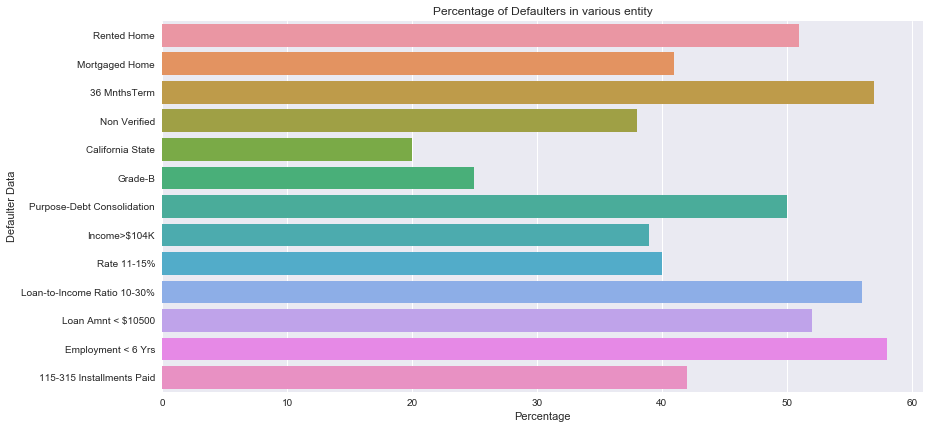

In [56]:
# Plotting the inferences against percentage
sns.set(style="darkgrid")
plt.figure(figsize=(30,15))
plt.subplot(221)
plt.title('Percentage of Defaulters in various entity')
output = sns.barplot(x='Percentage', y='Defaulter Data', data=final_df, estimator=np.sum, linewidth=10)
plt.show()

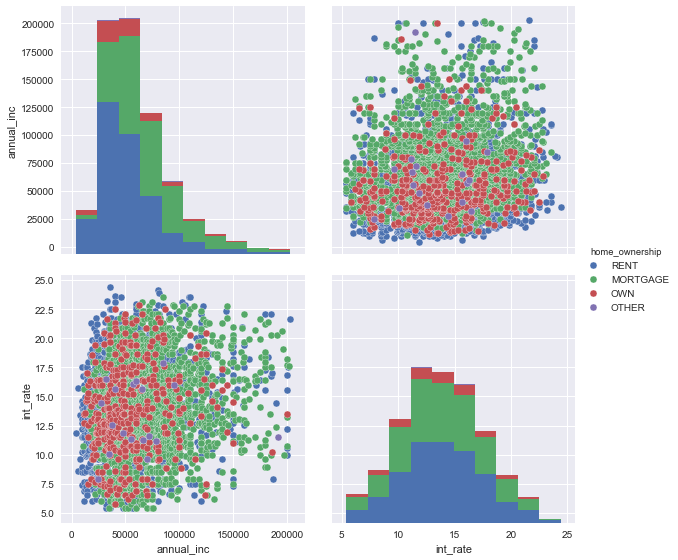

In [65]:
# Pair plot annual income to interest rate for the categorical variable - home ownership
pair = loan_def[['loan_amnt','term','installment','annual_inc','addr_state','total_acc','pub_rec',
                 'revol_util','emp_length','purpose','int_rate','grade','home_ownership','verification_status']]
pair_inc_rate = pair[['annual_inc','int_rate','home_ownership']]
sns.pairplot(pair_inc_rate, hue = 'home_ownership',kind = 'scatter',diag_kind ='hist',size=4)

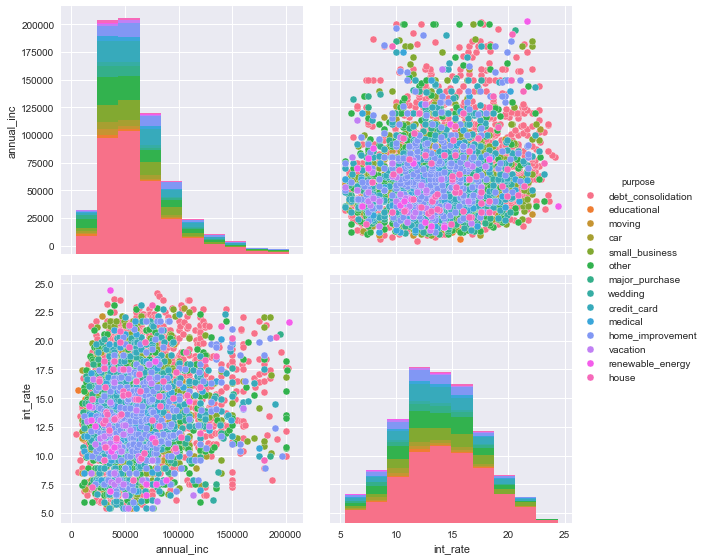

In [66]:
# Pair plot annual income to interest rate for the categorical variable - purpose
pair_inc_rate = pair[['annual_inc','int_rate','purpose']]
sns.pairplot(pair_inc_rate, hue = 'purpose',kind = 'scatter',diag_kind ='hist',size=4)

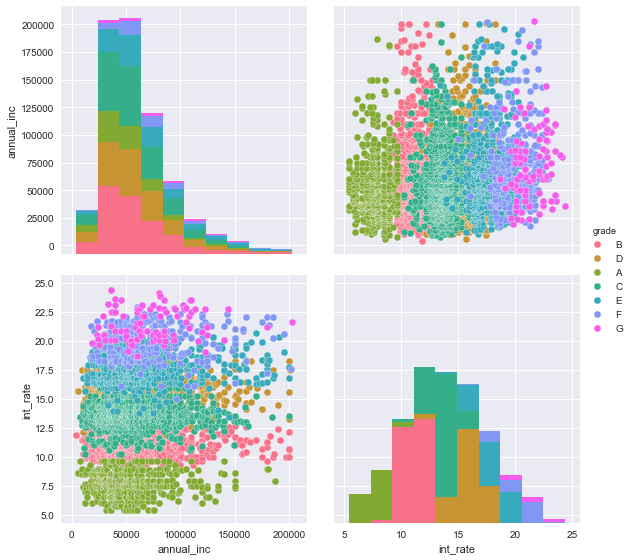

In [67]:
# Pair plot loan amount to total_acc for the categorical variable - grade
pair_inc_rate = pair[['annual_inc','int_rate','grade']]
sns.pairplot(pair_inc_rate, hue = 'grade',kind = 'scatter',diag_kind ='hist',size=4)

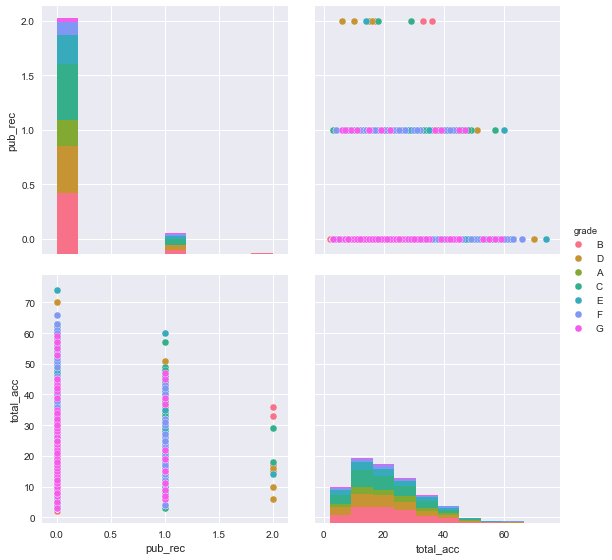

In [74]:
# Pair plot emp_length to total_acc for the categorical variable - purpose
pair_inc_rate = pair[['pub_rec','total_acc','grade']]
sns.pairplot(pair_inc_rate, hue = 'grade', kind = 'scatter', diag_kind ='hist',size=4)

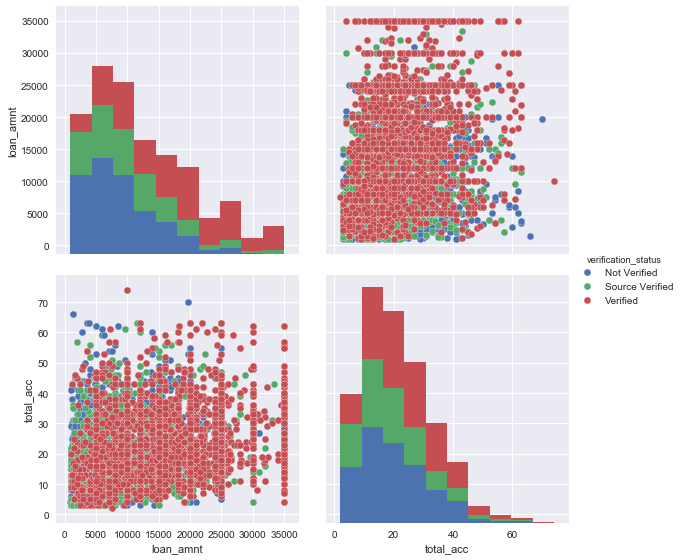

In [75]:
# Pair plot loan amount to total_acc for the categorical variable - verification_status
pair_inc_rate = pair[['loan_amnt','total_acc','verification_status']]
sns.pairplot(pair_inc_rate, hue = 'verification_status', kind = 'scatter', diag_kind ='hist', size=4)

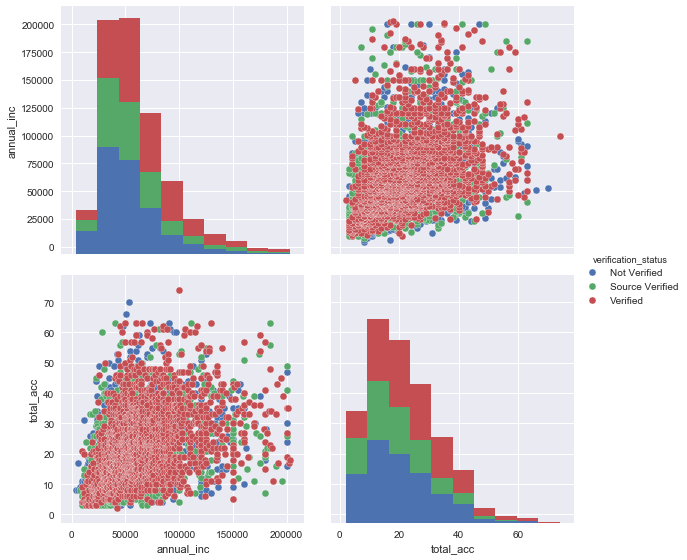

In [76]:
# Pair plot annual income to total_acc for the categorical variable - verification_status
pair_inc_rate = pair[['annual_inc','total_acc','verification_status']]
sns.pairplot(pair_inc_rate, hue = 'verification_status', kind = 'scatter', diag_kind ='hist', size=4)

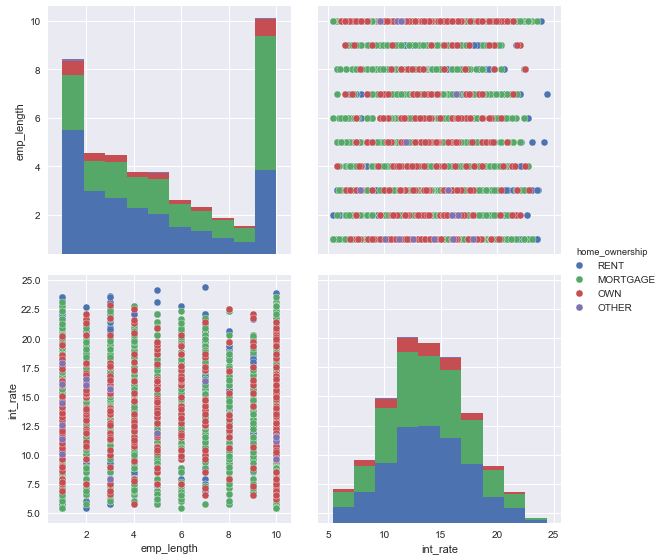

In [77]:
# Pair plot emp length to interest rate for the categorical variable - home ownership
pair = loan_def[['loan_amnt','term','installment','annual_inc','addr_state','total_acc',
                 'revol_util','emp_length','purpose','int_rate','grade','home_ownership','verification_status']]
pair_emplen_rate = pair[['emp_length','int_rate','home_ownership']]
sns.pairplot(pair_emplen_rate, hue = 'home_ownership', kind = 'scatter', diag_kind ='hist', size=4)

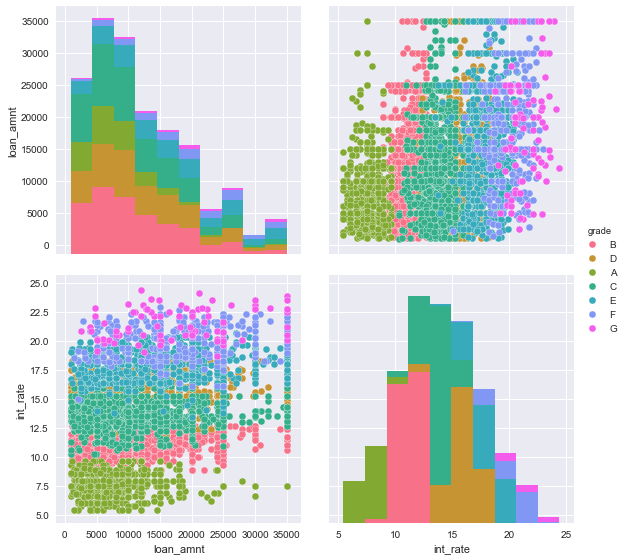

In [78]:
# Pair plot loan amount to interest rate for the categorical variable - grade
pair = loan_def[['loan_amnt','term','installment','annual_inc','addr_state','total_acc',
                 'revol_util','emp_length','purpose','int_rate','grade','home_ownership','verification_status']]
pair_emplen_rate = pair[['loan_amnt','int_rate','grade']]
sns.pairplot(pair_emplen_rate, hue = 'grade', kind = 'scatter', diag_kind ='hist', size=4)

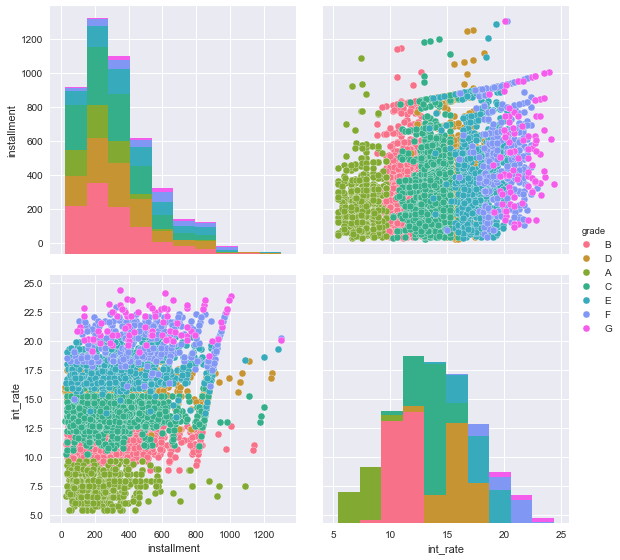

In [79]:
# Pair plot installment to interest rate for the categorical variable - grade
pair = loan_def[['loan_amnt','term','installment','annual_inc','addr_state','total_acc',
                 'revol_util','emp_length','purpose','int_rate','grade','home_ownership','verification_status']]
pair_emplen_rate = pair[['installment','int_rate','grade']]
sns.pairplot(pair_emplen_rate, hue = 'grade', kind = 'scatter', diag_kind ='hist', size=4)

# Bivariate - Crosstable data analysis for defaulters
The cross table values will be used for the inferences referenced in the above pair plots.

In [80]:
# The cross table values will be used for the inferences referenced in the above pair plots.

def percConvert(ser):
  """Convert values in %.To be used in all cross tables """
  return (ser/float(ser[-1])*100)

# Cross table for annual income and home ownership in percentage
table = (pd.crosstab(loan_def['annual_inc_bin'],loan_def['home_ownership'],margins=True).sort_values(
        'All',ascending=False)).apply(percConvert, axis=1)
table

home_ownership,MORTGAGE,OTHER,OWN,RENT,All
annual_inc_bin,,,,,
All,41.403904,0.337838,7.432432,50.825826,100.0
[29000-54000],31.253024,0.241896,8.272859,60.232221,100.0
[54000-79000],49.212598,0.524934,6.233596,44.028871,100.0
[79000-104000],61.255743,0.306279,5.972435,32.465544,100.0
[4000-29000],14.604811,0.343643,11.340206,73.711340,100.0
[104000-129000],64.028777,0.000000,5.035971,30.935252,100.0
[129000-154000],64.516129,0.000000,7.258065,28.225806,100.0
[154000-179000],74.074074,0.000000,0.000000,25.925926,100.0
[179000-204000],58.695652,2.173913,4.347826,34.782609,100.0


In [81]:
# Cross table for interest rate and home ownership in percentage
table = (pd.crosstab(loan_def['int_rate_bin'],loan_def['home_ownership'],margins=True).sort_values(
        'All',ascending=False)).apply(percConvert, axis=1)
table

home_ownership,MORTGAGE,OTHER,OWN,RENT,All
int_rate_bin,,,,,
All,41.403904,0.337838,7.432432,50.825826,100.0
[11.0-13.0],40.350877,0.646353,7.479224,51.523546,100.0
[13.0-15.0],39.268978,0.093721,7.029053,53.608247,100.0
[15.0-17.0],40.211640,0.634921,7.195767,51.957672,100.0
[9.0-11.0],44.221880,0.308166,7.395994,48.073960,100.0
[17.0-19.0],41.281139,0.177936,6.405694,52.135231,100.0
[7.0-9.0],42.408377,0.261780,8.638743,48.691099,100.0
[19.0-21.0],45.821326,0.000000,8.645533,45.533141,100.0
[5.0-7.0],45.806452,0.000000,7.741935,46.451613,100.0


In [82]:
# Cross table for annual income and purpose in percentage
table = (pd.crosstab(loan_def['purpose'], loan_def['annual_inc_bin'], margins=True).sort_values(
        'All',ascending=False)).apply(percConvert, axis=1)
table

annual_inc_bin,[104000-129000],[129000-154000],[154000-179000],[179000-204000],[29000-54000],[4000-29000],[54000-79000],[79000-104000],All
purpose,,,,,,,,,
All,5.217718,2.327327,1.013514,0.863363,38.795045,10.923423,28.603604,12.256006,100.0
debt_consolidation,4.932229,2.070783,1.204819,0.677711,39.570783,9.375000,30.271084,11.897590,100.0
other,5.831904,2.229846,0.686106,1.372213,40.651801,16.981132,23.327616,8.919383,100.0
credit_card,6.374502,2.589641,0.996016,0.398406,39.840637,7.171315,28.486056,14.143426,100.0
small_business,5.908096,2.407002,0.875274,1.750547,31.947484,9.628009,31.728665,15.754923,100.0
home_improvement,5.031447,5.031447,1.886792,1.572327,33.018868,5.974843,29.559748,17.924528,100.0
major_purchase,4.326923,1.923077,0.000000,0.961538,41.346154,20.673077,23.076923,7.692308,100.0
car,5.194805,0.649351,0.649351,0.000000,40.909091,15.584416,24.675325,12.337662,100.0
medical,4.000000,3.000000,1.000000,0.000000,32.000000,15.000000,32.000000,13.000000,100.0


In [83]:
# Cross table for purpose and interest in percentage
table = (pd.crosstab(loan_def['purpose'], loan_def['int_rate_bin'], margins=True).sort_values(
        'All',ascending=False)).apply(percConvert, axis=1)
table

int_rate_bin,[11.0-13.0],[13.0-15.0],[15.0-17.0],[17.0-19.0],[19.0-21.0],[21.0-23.0],[23.0-25.0],[5.0-7.0],[7.0-9.0],[9.0-11.0],All
purpose,,,,,,,,,,,
All,20.326577,20.026276,17.736486,10.548048,6.512763,2.346096,0.243994,2.909159,7.169670,12.180931,100.0
debt_consolidation,18.486446,20.180723,18.486446,12.650602,7.906627,2.786145,0.338855,2.748494,5.722892,10.692771,100.0
other,20.068611,19.897084,19.210978,7.890223,4.288165,1.200686,0.171527,2.744425,9.605489,14.922813,100.0
credit_card,24.302789,22.310757,15.338645,7.968127,5.976096,1.992032,0.199203,4.183267,6.175299,11.553785,100.0
small_business,20.131291,18.818381,17.724289,11.159737,7.877462,4.595186,0.000000,2.625821,5.032823,12.035011,100.0
home_improvement,22.327044,20.440252,16.037736,7.547170,5.345912,1.572327,0.000000,2.830189,9.119497,14.779874,100.0
major_purchase,22.596154,23.557692,16.826923,7.692308,2.884615,0.000000,0.000000,2.884615,12.980769,10.576923,100.0
car,22.077922,12.337662,15.584416,11.038961,0.649351,0.649351,0.000000,1.948052,15.584416,20.129870,100.0
medical,23.000000,22.000000,19.000000,6.000000,6.000000,1.000000,0.000000,3.000000,7.000000,13.000000,100.0


In [84]:
# Cross table for credit lines and grade in percentage
table = (pd.crosstab(loan_def['total_acc_bin'], loan_def['grade'], margins=True).sort_values(
        'All',ascending=False)).apply(percConvert, axis=1)
table

grade,A,B,C,D,E,F,G,All
total_acc_bin,,,,,,,,
All,10.454204,25.187688,23.967718,20.157658,12.800300,5.649399,1.783033,100.0
[12-22],10.015814,25.461255,24.617818,20.031629,12.493411,5.798629,1.581444,100.0
[22-32],11.419985,27.122464,22.915101,20.135237,12.246431,4.733283,1.427498,100.0
[2-12],8.597285,22.262443,25.339367,22.986425,13.484163,5.067873,2.262443,100.0
[32-42],11.901306,26.415094,23.657475,17.706821,12.917271,6.095791,1.306241,100.0
[42-52],12.831858,25.221239,19.911504,16.814159,15.486726,6.637168,3.097345,100.0
[52-62],11.290323,19.354839,17.741935,12.903226,9.677419,20.967742,8.064516,100.0
[62-72],11.764706,5.882353,35.294118,23.529412,11.764706,11.764706,0.000000,100.0
[72-82],0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,100.0


In [85]:
# Cross table forpurpose and emp length in percentage
table = (pd.crosstab(loan_def['purpose'], loan_def['emp_length_bin'], margins=True).sort_values(
        'All',ascending=False)).apply(percConvert, axis=1)
table

emp_length_bin,[0-3],[3-6],[6-9],[9-12],All
purpose,,,,,
All,30.818318,27.308559,14.301802,27.571321,100.0
debt_consolidation,29.066265,25.978916,15.286145,29.668675,100.0
other,34.819897,26.415094,12.349914,26.415094,100.0
credit_card,27.490040,29.880478,15.737052,26.892430,100.0
small_business,33.698031,30.415755,12.472648,23.413567,100.0
home_improvement,27.987421,25.157233,12.578616,34.276730,100.0
major_purchase,34.134615,32.692308,10.576923,22.596154,100.0
car,31.818182,28.571429,16.883117,22.727273,100.0
medical,35.000000,23.000000,17.000000,25.000000,100.0


In [86]:
# Cross table for purpose and credit lines in percentage
table = (pd.crosstab(loan_def['purpose'], loan_def['total_acc_bin'], margins=True).sort_values(
        'All',ascending=False)).apply(percConvert, axis=1)
table

total_acc_bin,[12-22],[2-12],[22-32],[32-42],[42-52],[52-62],[62-72],[72-82],All
purpose,,,,,,,,,
All,35.604354,20.739489,24.981231,12.931682,4.241742,1.163664,0.319069,0.018769,100.0
debt_consolidation,35.655120,16.980422,26.731928,14.006024,4.932229,1.280120,0.376506,0.037651,100.0
other,35.334477,29.331046,21.097770,10.463122,2.915952,0.686106,0.171527,0.000000,100.0
credit_card,37.250996,11.354582,29.880478,15.537849,4.780876,0.796813,0.398406,0.000000,100.0
small_business,38.293217,23.632385,22.538293,9.846827,3.501094,2.188184,0.000000,0.000000,100.0
home_improvement,35.534591,15.723270,27.044025,16.981132,3.144654,0.943396,0.628931,0.000000,100.0
major_purchase,36.057692,33.653846,19.230769,7.692308,2.884615,0.480769,0.000000,0.000000,100.0
car,34.415584,29.870130,18.831169,11.688312,4.545455,0.000000,0.649351,0.000000,100.0
medical,34.000000,29.000000,21.000000,11.000000,2.000000,3.000000,0.000000,0.000000,100.0


In [87]:
# Cross table for credit lines and verification status in percentage
table = (pd.crosstab(loan_def['total_acc_bin'], loan_def['verification_status'], margins=True).sort_values(
        'All',ascending=False)).apply(percConvert, axis=1)
table

verification_status,Not Verified,Source Verified,Verified,All
total_acc_bin,,,,
All,38.025526,25.863363,36.111111,100.0
[12-22],39.694254,27.886136,32.419610,100.0
[22-32],35.687453,22.990233,41.322314,100.0
[2-12],42.805430,31.402715,25.791855,100.0
[32-42],33.526851,19.883890,46.589260,100.0
[42-52],31.415929,19.469027,49.115044,100.0
[52-62],25.806452,19.354839,54.838710,100.0
[62-72],41.176471,17.647059,41.176471,100.0
[72-82],0.000000,0.000000,100.000000,100.0


In [88]:
# Cross table for emp length and homeownership in percentage
table = (pd.crosstab(loan_def['emp_length_bin'],loan_def['home_ownership'],margins=True).sort_values(
        'All',ascending=False)).apply(percConvert, axis=1)
table

home_ownership,MORTGAGE,OTHER,OWN,RENT,All
emp_length_bin,,,,,
All,41.403904,0.337838,7.432432,50.825826,100.0
[0-3],29.110840,0.487211,7.429963,62.971985,100.0
[9-12],55.752212,0.340368,7.624234,36.283186,100.0
[3-6],38.900344,0.274914,6.941581,53.883162,100.0
[6-9],45.013123,0.131234,8.005249,46.850394,100.0


In [89]:
# Cross table for interest rate and grade in percentage
table = (pd.crosstab(loan_def['int_rate_bin'],loan_def['grade'],margins=True).sort_values(
        'All',ascending=False)).apply(percConvert, axis=1)
table

grade,A,B,C,D,E,F,G,All
int_rate_bin,,,,,,,,
All,10.454204,25.187688,23.967718,20.157658,12.800300,5.649399,1.783033,100.0
[11.0-13.0],0.000000,67.036011,29.916898,3.047091,0.000000,0.000000,0.000000,100.0
[13.0-15.0],0.000000,0.000000,76.476101,22.305530,1.218369,0.000000,0.000000,100.0
[15.0-17.0],0.000000,0.000000,13.121693,64.867725,21.375661,0.634921,0.000000,100.0
[9.0-11.0],5.546995,92.449923,2.003082,0.000000,0.000000,0.000000,0.000000,100.0
[17.0-19.0],0.000000,0.000000,0.000000,33.807829,51.601423,14.412811,0.177936,100.0
[7.0-9.0],95.811518,4.188482,0.000000,0.000000,0.000000,0.000000,0.000000,100.0
[19.0-21.0],0.000000,0.000000,0.000000,0.000000,51.008646,36.023055,12.968300,100.0
[5.0-7.0],100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.0


In [90]:
# Cross table for installment and grade in percentage
table = (pd.crosstab(loan_def['installment_bin'],loan_def['grade'],margins=True).sort_values(
        'All',ascending=False)).apply(percConvert, axis=1)
table

grade,A,B,C,D,E,F,G,All
installment_bin,,,,,,,,
All,10.454204,25.187688,23.967718,20.157658,12.800300,5.649399,1.783033,100.0
[215-415],11.461022,25.916366,24.264326,21.218379,11.770780,3.975219,1.393908,100.0
[15-215],15.334421,28.765633,26.427406,18.325177,8.374116,2.229473,0.543774,100.0
[415-615],4.603854,21.520343,24.197002,22.483940,16.167024,8.672377,2.355460,100.0
[615-815],1.574803,23.884514,16.535433,14.435696,23.097113,15.223097,5.249344,100.0
[815-1015],1.376147,7.798165,12.844037,24.770642,26.605505,19.724771,6.880734,100.0
[1015-1215],7.142857,14.285714,28.571429,35.714286,14.285714,0.000000,0.000000,100.0
[1215-1415],0.000000,0.000000,0.000000,40.000000,20.000000,20.000000,20.000000,100.0
